In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt
import argparse
from scipy import stats
from scipy.optimize import minimize
from scipy.stats.distributions import chi2

import scipy

'''
Inputs
'''
#parser = argparse.ArgumentParser(description = "Takes I3Photons from step2 of the simulations and generates DOM hits")
#parser.add_argument('-i', '--infile', dest = 'infile', help= 'input file and path')
#parser.add_argument('-o', '--outfile', dest = 'outfile', help= 'output file and path')
#args = parser.parse_args()

infile = '/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(713)+'_medium_water_custom_mDOM_noise.i3.gz'

In [2]:
'''
Functions
'''

def gaussian(x, pos, wid, amp):
    y = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    return y

def biGauss(x, pos, wid, r, amp):
    mask = x < pos

    y_all = ([])
    for i in range(0, len(mask)):

        if mask[i] == True:
            m = 1
            nm = 0
        else:
            m = 0
            nm = 1
        if r != 0:
            y1 = gaussian(x[i],pos,r*wid/(r+1),amp)*m
            y2 = gaussian(x[i],pos,wid/(r+1),amp)*nm
            y = y1 + y2
        else:
            y = gaussian(x[i],pos,wid, amp)*nm

        y_all = np.append(y_all, y)
    return y_all

def double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    b1 = biGauss(x, pos1, wid1, r1, amp1)
    b2 = biGauss(x, pos2, wid2, r2, amp2)
    b = np.append(b1, b2)
    return b1+b2

def log_likelihood_biGauss(theta, n, x):
    pos, wid, r, amp = theta
    model = biGauss(x, pos, wid, r, amp)
    L = model - (n*np.log(model))
    return np.sum(L)

def log_likelihood_doublePeak(theta, n, x):
    pos1, wid1, r1, amp1, pos2, wid2, r2, amp2 = theta
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    L = model - (n*np.log(model))
    return np.sum(L)

def likelihood_ratio_doublePeak(x, n, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    val = model - n + (n*np.log(n/model))
    #print('log - ', n/model, 'n - ', n)
    return np.sum(val)

def likelihood_ratio_biGauss(x, n, pos, wid, r, amp):
    model = biGauss(x, pos, wid, r, amp)
    val = model - n + (n*np.log(n/model))
    #print('log - ', n/model, 'n - ', n)
    return np.sum(val)

In [3]:
gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
omgeo = geometry.omgeo
print('loaded geometry')

loaded geometry


In [42]:
def likelihoodfit():

    print('LikelihoodFit')
    tau_timeDiff = ([])
    tau_pVal = ([])
    tau_LRR = ([])
    tau_wid1_ratio = ([])
    tau_wid2_ratio = ([])
    tau_amp1_ratio = ([])
    tau_amp2_ratio = ([])

    e_timeDiff = ([])
    e_pVal = ([])
    e_LRR = ([])
    e_wid1_ratio = ([])
    e_wid2_ratio = ([])
    e_amp1_ratio = ([])
    e_amp2_ratio = ([])

    tau_wid_ratio_dp = ([])
    e_wid_ratio_dp = ([])
    tau_amp_ratio_dp = ([])
    e_amp_ratio_dp = ([])

    #print('FILE NUMBER - ', str(args.infile))
    #file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')
    file = dataio.I3File(str(infile))

    f = 1

    #txt_file = open("/data/p-one/akatil/analysis/25_30/files_greater_than_100.txt", "a")

    for frame in file:
        #print('frame num - ', f)
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        for omkey in mcpeMap.keys():
            oKey = omgeo.get(omkey)

            '''
            Obtaining the timeList
            '''
            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)


            '''
            Removing DOMs with hits less than 250 Hits
            '''
            if len(tot_timeList) < 250:
                continue


            '''
            Calculating the mean and removing the tails
            '''

            timeList = timeList[timeList < min(timeList)+30]

            mean_physicsHits = timeList.mean()
            mean_tot = tot_timeList.mean()

            select_time = tot_timeList[(tot_timeList > mean_tot-50) & (tot_timeList < mean_tot+50)]
            new_mean = select_time.mean()

            bins = np.arange(min(select_time), max(select_time), 1)
            max_hitTimes = select_time[(select_time > (new_mean-40))&(select_time < (new_mean+40))]

            z = stats.zscore(max_hitTimes)

            #using zscore to remove the effect of outliers from the analysis]
            max_hitTimes = max_hitTimes[(z>-1.6)&(z < 1.2)]
            new_mean = max_hitTimes.mean()
            timestamps = max_hitTimes - new_mean
            final_mean = timestamps.mean()

            num_photons = len(max_hitTimes[max_hitTimes>0])

            if len(max_hitTimes) < 250:
                continue

            #if np.log10(num_photons) >= 3.0 or np.log10(num_photons) < 2.5:
                #continue

            '''
            Histogramming the data from simulation
            '''

            bins = np.arange(min(timestamps), max(timestamps), 1)
            num, bin_edges = np.histogram(timestamps, bins=bins)
            bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

            #print('LOG LIKELIHOOD')

            '''
            Removing DOMs that don't have less than 8 non zero bins
            '''
            if len(num[num>0]) <= 8:
                continue



            '''
            Fitting bifurcated Gaussian and double bifurcated gaussian to the mcpe hit time distributions
            for both tau and electron.
            '''
            
            nll = lambda *args: log_likelihood_biGauss(*args)
            initial_biGauss = np.array([final_mean, 50, 5, max(num)])
            #bnds_biGauss = ((min(bin_centers), mean_timeArrival), (0, 20), (0, 2), (0, max(num)), (mean_timeArrival, max(bin_centers)), (0, 20), (0, 2), (0, max(num)))

            #print(len(num), len(initial_biGauss), initial_biGauss)
            bnds_biGauss = ((min(bin_centers), max(bin_centers)), (0, 100), (0, 10), (0, 1e6))
            print('----------BOUNDS-----------')
            print(bnds_biGauss)
            soln_biGauss = minimize(log_likelihood_biGauss, initial_biGauss, args=(num, bin_centers),
                                    method='Powell', bounds = bnds_biGauss)

            nll = lambda *args: log_likelihood_doublePeak(*args)
            initial_doublePeak = np.array([min(bin_centers)+10, 20, 1, max(num), final_mean, 20, 1, max(num)])
            bnds_doublePeak = ((min(bin_centers), final_mean), (0, 100), (0, 10), (0, 1e6),
                               (final_mean, max(bin_centers)), (0, 100), (0, 10), (0,1e6))
            soln_doublePeak = minimize(log_likelihood_doublePeak, initial_doublePeak, args=(num, bin_centers),
                                    method='Powell',bounds=bnds_doublePeak)
                
            '''
            Removing DOMs whose minimization is not successful
            '''
            #if soln_biGauss.success == False or soln_doublePeak.success == False:
                #print('Removing DOMs whose minimization is not successful')
                #continue

            '''
            Calculating the Likelihood ratio for bifurcated gaussian and double double bifurcated gaussian
            '''
            LR_biGauss = likelihood_ratio_biGauss(bin_centers[num>0], num[num>0], soln_biGauss.x[0],
                                             soln_biGauss.x[1], soln_biGauss.x[2], soln_biGauss.x[3])
            LR_doublePeak = likelihood_ratio_doublePeak(bin_centers[num>0], num[num>0], soln_doublePeak.x[0], soln_doublePeak.x[1],
                                             soln_doublePeak.x[2], soln_doublePeak.x[3], soln_doublePeak.x[4],
                                             soln_doublePeak.x[5], soln_doublePeak.x[6], soln_doublePeak.x[7])
            


            '''
            Calculating the p-value using the likelihood ratio
            '''
            pVal_biGauss = chi2.sf(LR_biGauss, len(num) - 4)
            pVal_doublePeak = chi2.sf(LR_doublePeak, len(num) - 8)

            if pVal_biGauss != pVal_biGauss:
                print('BiGauss is not well defined - ', str(lepton.type))
                print('Minimisation - ', soln_biGauss.success)
                print('Degrees of Freedom - ', len(num) - 4)
                print('Log Likelihood - ', LR_biGauss)
            if pVal_doublePeak != pVal_doublePeak:
                print('double peak is not well defined - ', str(lepton.type))
                print('Minimisation - ', soln_doublePeak.success)
                print('Degrees of Freedom - ', len(num) - 8)
                print('Log Likelihood - ', LR_doublePeak)

            '''
            (x, y) values for the fit
            '''
            x = np.linspace(min(bin_centers), max(bin_centers), 1000)
            #x = np.linspace(0, max(bin_centers)+1e5, 1000)
            y_biGauss = biGauss(x, soln_biGauss.x[0],
                                            soln_biGauss.x[1], soln_biGauss.x[2], soln_biGauss.x[3])
            y_doublePeak = double_peak(x, soln_doublePeak.x[0], soln_doublePeak.x[1],
                                            soln_doublePeak.x[2], soln_doublePeak.x[3], soln_doublePeak.x[4],
                                            soln_doublePeak.x[5], soln_doublePeak.x[6], soln_doublePeak.x[7])

            '''
            Calculating the time difference and p-value ratio of bigauss and double peak
            '''
            timeDifference_doublePeak = soln_doublePeak.x[4] - soln_doublePeak.x[0]
            pVal_ratio = pVal_doublePeak/pVal_biGauss
            LRR = LR_doublePeak/LR_biGauss
            wid1_ratio = soln_doublePeak.x[1]/soln_biGauss.x[1]
            wid2_ratio = soln_doublePeak.x[5]/soln_biGauss.x[1]
            amp1_ratio = soln_doublePeak.x[3]/soln_biGauss.x[3]
            amp2_ratio = soln_doublePeak.x[7]/soln_biGauss.x[3]
            wid1_wid2 = soln_doublePeak.x[1]/soln_doublePeak.x[5]
            amp1_amp2 = soln_doublePeak.x[3]/soln_doublePeak.x[7]



            '''
            Removing terrible fits
            '''
            if abs(timeDifference_doublePeak) > 100:
                #print('*****----------timeDifference > 100----------********')
                #print(abs(LR_biGauss-LR_doublePeak))
                #print(str(args.infile)+'----->', timeDifference_doublePeak)
                #txt_file.write('File - '+str(args.infile)+' - Frame Number - '+str(f)+' - OMKey - '+str(omkey)+ ' - Time Difference - '+str(timeDifference_doublePeak)+'-\n')
                #continue
                
                plt.figure(figsize=(10,9))
                _ = plt.hist(timestamps, bins=bins, histtype='step')
                plt.title(str(lepton.type)+' timeDifference > 100 ' + str(abs(LR_biGauss/LR_doublePeak)))
                plt.plot(x, y_biGauss, '--', c = 'r')
                plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(final_mean, c = 'b')
                
            else:
                #print('*****----------timeDifference < 100----------********')
                #print(abs(LR_biGauss-LR_doublePeak))
                
                plt.figure(figsize=(10,9))
                _ = plt.hist(timestamps, bins=bins, histtype='step')
                plt.title(str(lepton.type)+' timeDifference < 100 '+ str(abs(LR_biGauss/LR_doublePeak)))
                plt.plot(x, y_biGauss, '--', c = 'r')
                plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(final_mean, c = 'b')

            amp1 = soln_doublePeak.x[3]
            amp2 = soln_doublePeak.x[7]
            if amp1/amp2 < 1/4 and amp1/amp2 > 4:
                print('Removing terrible fits')
                continue

            if amp1 < 0 or amp2 < 0:
                print('Error in amp')
                '''
                plot mcpe time distributions obtained using simulations and the fits
                '''
                plt.figure(figsize=(10,9))
                _ = plt.hist(timestamps, bins=bins, histtype='step')
                plt.title(str(lepton.type)+' ERROR IN AMP')
                #plt.plot(x, y_biGauss, '--', c = 'r')
                #plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(final_mean, c = 'b')
                
                print(soln_doublePeak, soln_biGauss)


                continue

            print('Reached Here')


            '''
            plot mcpe time distributions obtained using simulations and the fits
            '''
            #plt.figure(figsize=(10,9))
            #_ = plt.hist(timestamps, bins=bins, histtype='step')
            #plt.title(str(lepton.type))
            #plt.plot(x, y_biGauss, '--', c = 'r')
            #plt.plot(x, y_doublePeak, '--', c = 'k')
            #plt.axvline(final_mean, c = 'b')


            '''
            Separating the time difference calculated above and appending the values
            '''

            '''
            Tau
            '''
            if lepton.type == 15 or lepton.type == -15:
                tau_timeDiff = np.append(tau_timeDiff, timeDifference_doublePeak)
                tau_pVal = np.append(tau_pVal, pVal_ratio)
                tau_LRR = np.append(tau_LRR, LRR)
                tau_wid1_ratio = np.append(tau_wid1_ratio, wid1_ratio)
                tau_wid2_ratio = np.append(tau_wid2_ratio, wid2_ratio)
                tau_amp1_ratio = np.append(tau_amp1_ratio, amp1_ratio)
                tau_amp2_ratio = np.append(tau_amp2_ratio, amp2_ratio)

                tau_wid_ratio_dp = np.append(tau_wid_ratio_dp, wid1_wid2)
                tau_amp_ratio_dp = np.append(tau_amp_ratio_dp, amp1_amp2)
                #plt.title('E')

            '''
            Electron and Neutral Current
            '''

            if lepton.type == 11 or lepton.type == -11 or lepton.type == 12 or lepton.type == -12 or lepton.type == 16 or lepton.type == -16:

                e_timeDiff = np.append(e_timeDiff, timeDifference_doublePeak)
                e_pVal = np.append(e_pVal, pVal_ratio)
                e_LRR = np.append(e_LRR, LRR)
                e_wid1_ratio = np.append(e_wid1_ratio, wid1_ratio)
                e_wid2_ratio = np.append(e_wid2_ratio, wid2_ratio)
                e_amp1_ratio = np.append(e_amp1_ratio, amp1_ratio)
                e_amp2_ratio = np.append(e_amp2_ratio, amp2_ratio)

                e_wid_ratio_dp = np.append(e_wid_ratio_dp, wid1_wid2)
                e_amp_ratio_dp = np.append(e_amp_ratio_dp, amp1_amp2)

            #print('P-VAL CALCULATED')

        f = f+1

    #txt_file.close()

Starting
[6.92615955]
Starting
[8.01509652]
Starting
[7.74887335]
Starting
[5.31716524]
Starting
[8.31380244]
Starting
[4.64522921]
Starting
[8.085902]
Starting
[8.24826947]
Starting
[5.07340513]
Starting
[5.75979367]
LikelihoodFit
----------BOUNDS-----------
((-8.694274477660656, 14.305725522339344), (0, 100), (0, 10), (0, 1000000.0))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


Reached Here
----------BOUNDS-----------
((-6.385619893670082, 7.614380106329918), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-10.389630511403084, 12.610369488596916), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-17.836744084954262, 19.163255915045738), (0, 100), (0, 10), (0, 1000000.0))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in divide


Error in amp
(   direc: array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 36.78998641,  -6.06019643,  -1.67586111,  23.67916163,
          0.58679918,   7.76632327,   6.86866861, -31.25441672],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ,   0.        ],
       [  6.50698249,   4.32389316,   3.01057384,   1.20638283,
         

/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


Reached Here
----------BOUNDS-----------
((-16.4032194390893, 17.5967805609107), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-12.868364949215902, 13.131635050784098), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-7.022651850478724, 6.977348149521276), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-6.155685417208588, 7.844314582791412), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
Starting
[5.30288155]
Starting
[7.21803402]
Starting
[7.45437772]
Starting
[8.24056047]
Starting
[7.16548026]
Starting
[8.05662711]


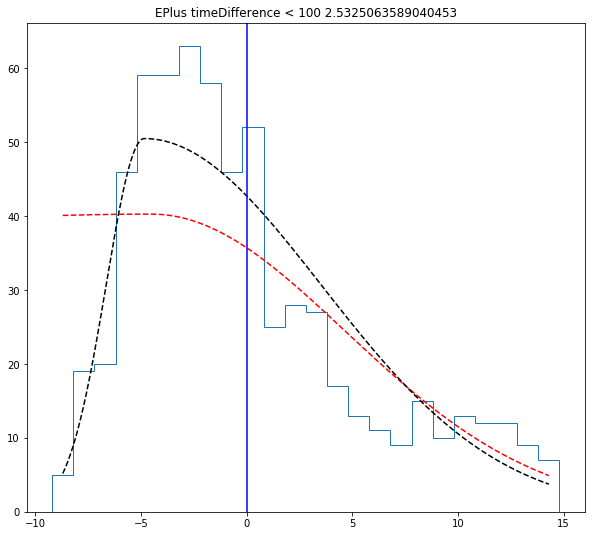

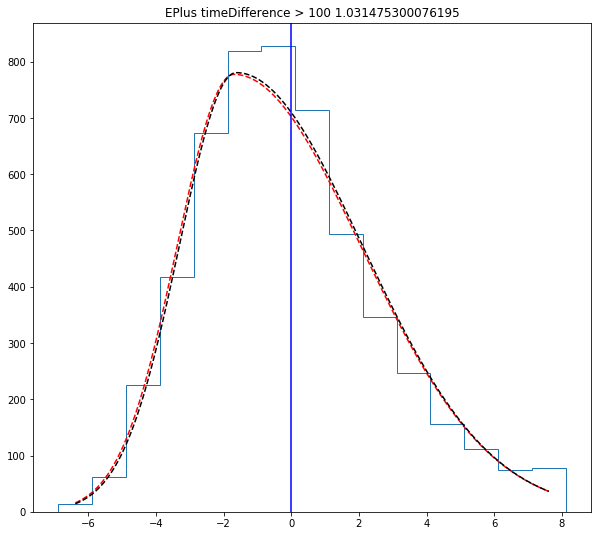

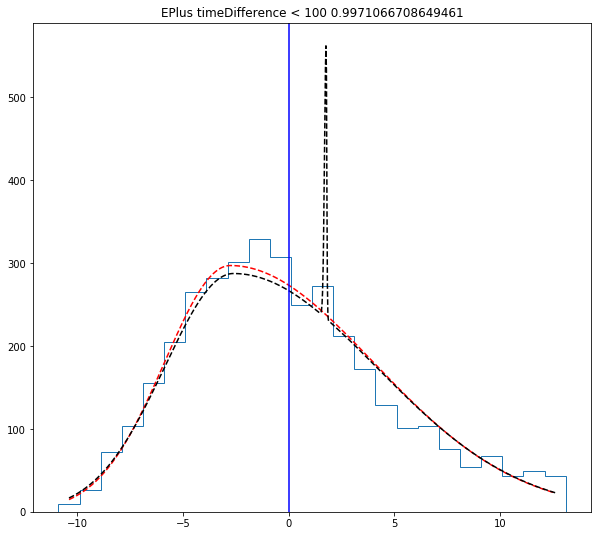

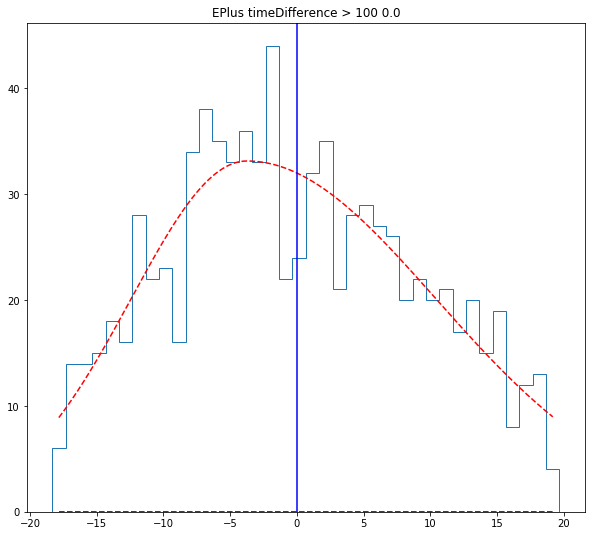

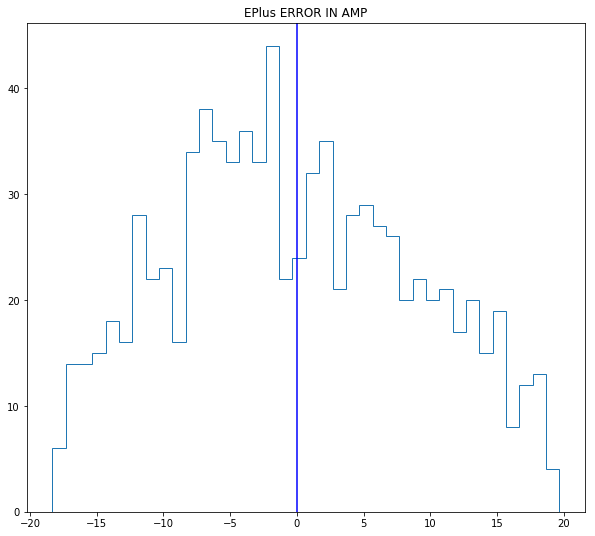

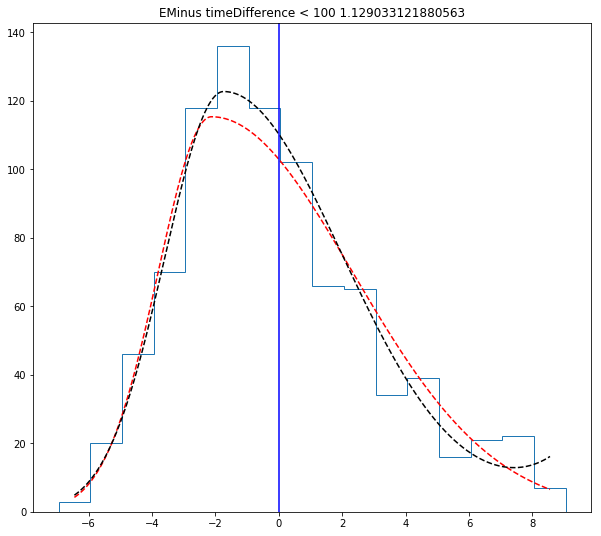

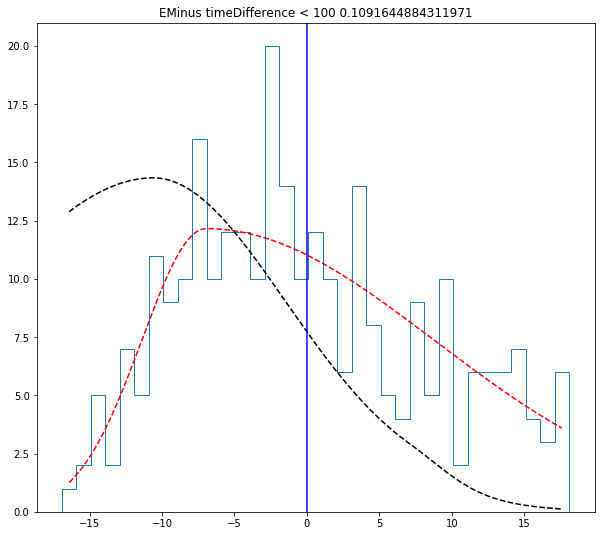

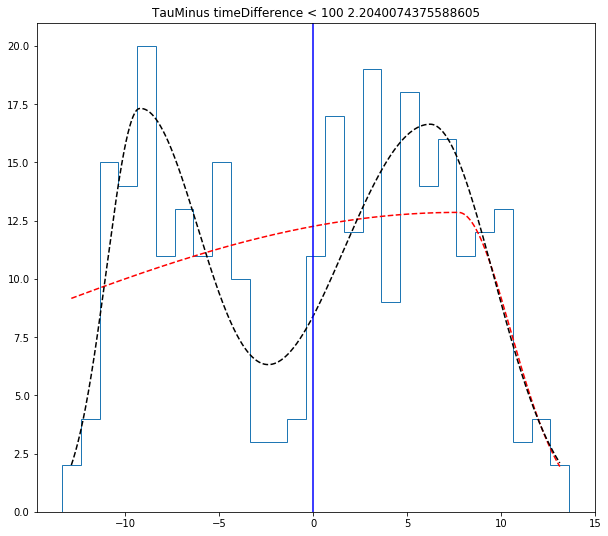

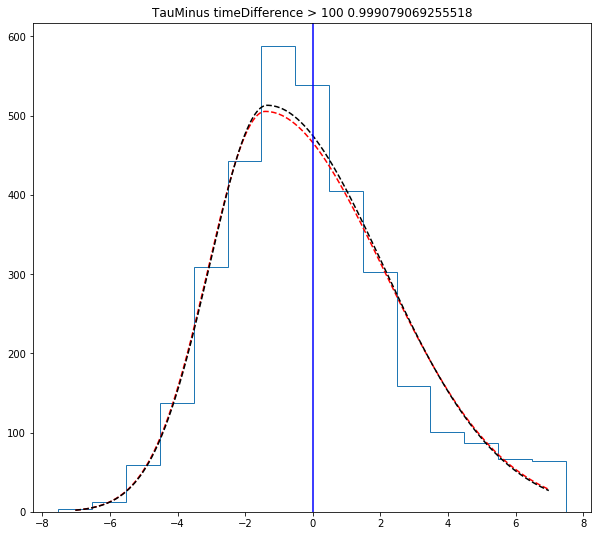

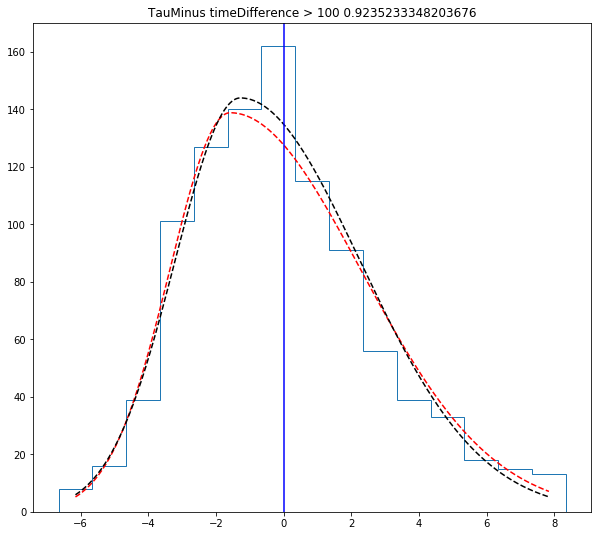

In [43]:
file = dataio.I3File(str(infile))

for frame in file:
    print('Starting')
    numHitsinDOM = ([])
    numHits = ([])
    mctree = frame["I3MCTree"]
    primary = mctree.primaries
    lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

    mcpeMap = frame['MCPESeriesMap']
    noiseMap = frame['NoiseSeriesMap']

    #looping through doms that have physics hits
    for omkey in mcpeMap.keys():
        oKey = omgeo.get(omkey)

        '''
        Obtaining the timeList
        '''
        noise_mcpeList = noiseMap[omkey]
        noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
        mcpeList = mcpeMap[omkey]
        timeList = np.array([mcpe.time for mcpe in mcpeList])
        tot_timeList = np.append(timeList, noise_timeList)
        numHitsinDOM = np.append(tot_timeList, noise_timeList)

        #print(numHitsinDOM)

    numHits = np.append(numHits, sum(numHitsinDOM))
    log_numHits = np.log10(numHits[numHits > 0])
    print(log_numHits)
    if log_numHits > 5.5 and log_numHits <= 6.0:
        likelihoodfit()


In [6]:
tot = ([])
for i in range(0, 2000):
    print(i)
    file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')
    
    for frame in file:
        print('Starting')
        numHitsinDOM = ([])
        numHits = ([])
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        #looping through doms that have physics hits
        for omkey in mcpeMap.keys():
            oKey = omgeo.get(omkey)

            '''
            Obtaining the timeList
            '''
            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)
            numHitsinDOM = np.append(numHitsinDOM, len(tot_timeList))

            #print(numHitsinDOM)

        numHits = np.append(numHits, sum(numHitsinDOM))
        log_numHits = np.log10(numHits[numHits > 0])
        tot = np.append(tot, log_numHits)
        print(log_numHits)

0
Starting
[1.2787536]
Starting
[2.94349452]
Starting
[2.19865709]
Starting
[2.15228834]
Starting
[2.29885308]
Starting
[2.38560627]
Starting
[2.49968708]
Starting
[0.95424251]
Starting
[0.84509804]
Starting
[2.07918125]
Starting
[0.84509804]
Starting
[1.30103]
Starting
[2.51188336]
Starting
[1.32221929]
Starting
[0.69897]
Starting
[2.73078228]
1
Starting
[1.5563025]
Starting
[2.56466606]
Starting
[0.60205999]
Starting
[0.30103]
Starting
[0.84509804]
Starting
[2.43136376]
Starting
[2.97634998]
Starting
[0.47712125]
Starting
[0.30103]
Starting
[1.61278386]
Starting
[2.18469143]
Starting
[2.07554696]
Starting
[0.47712125]
Starting
[3.44886085]
Starting
[2.12385164]
Starting
[1.23044892]
Starting
[2.00432137]
2
Starting
[2.49968708]
Starting
[1.86923172]
Starting
[1.64345268]
Starting
[4.13366662]
Starting
[2.86864444]
Starting
[2.88649073]
Starting
[1.41497335]
Starting
[1.92427929]
Starting
[4.7921044]
Starting
[2.18469143]
Starting
[1.69019608]
Starting
[1.78532984]
Starting
[2.5415792

[3.66791969]
Starting
[3.76402661]
Starting
[3.14270225]
Starting
[2.26951294]
Starting
[1.92941893]
Starting
[1.94448267]
Starting
[3.06107532]
Starting
[2.37474835]
Starting
[2.92324402]
Starting
[2.42813479]
Starting
[2.93298082]
Starting
[2.30749604]
Starting
[2.28780173]
25
Starting
[2.32428246]
Starting
[2.18752072]
Starting
[2.17897695]
Starting
[2.05307844]
Starting
[2.30749604]
Starting
[3.79518459]
Starting
[3.2367891]
Starting
[1.65321251]
Starting
[1.92427929]
Starting
[2.16731733]
Starting
[1.47712125]
Starting
[1.97312785]
Starting
[2.90145832]
Starting
[2.67486114]
Starting
[1.34242268]
Starting
[1.20411998]
26
Starting
[2.09342169]
Starting
[1.80617997]
Starting
[0.69897]
Starting
[1.50514998]
Starting
[1.95424251]
Starting
[2.04921802]
Starting
[1.25527251]
Starting
[3.75381278]
Starting
[3.02734961]
Starting
[1.54406804]
Starting
[2.4578819]
Starting
[1.14612804]
Starting
[0.69897]
27
Starting
[0.30103]
Starting
[2.61489722]
Starting
[1.92427929]
Starting
[1.44715803]

[2.18469143]
Starting
[1.44715803]
Starting
[1.75587486]
Starting
[1.5563025]
Starting
[2.29666519]
Starting
[2.95760729]
Starting
[2.49831055]
50
Starting
[2.12057393]
Starting
[1.34242268]
Starting
[3.0685569]
Starting
[1.98677173]
Starting
[1.8573325]
Starting
[2.31175386]
Starting
[0.90308999]
Starting
[3.20574554]
Starting
[2.44090908]
Starting
[2.17026172]
Starting
[3.07040732]
Starting
[1.2787536]
Starting
[3.63367041]
Starting
[1.5563025]
51
Starting
[1.66275783]
Starting
[1.64345268]
Starting
[2.70070372]
Starting
[2.03342376]
Starting
[1.5797836]
Starting
[3.12155984]
Starting
[0.47712125]
Starting
[2.68930886]
Starting
[2.17609126]
Starting
[1.56820172]
Starting
[2.31175386]
Starting
[1.44715803]
Starting
[3.93434693]
Starting
[1.83884909]
Starting
[0.77815125]
52
Starting
[1.59106461]
Starting
[1.69019608]
Starting
[3.69284692]
Starting
[3.02036128]
Starting
[1.30103]
Starting
[1.71600334]
Starting
[1.53147892]
Starting
[1.43136376]
Starting
[0.60205999]
Starting
[1.7708520

Starting
[1.38021124]
74
75
Starting
[1.30103]
Starting
[2.00432137]
Starting
[1.92427929]
Starting
[1.23044892]
Starting
[2.2121876]
Starting
[0.30103]
Starting
[1.462398]
Starting
[1.07918125]
Starting
[2.45939249]
Starting
[3.22762965]
Starting
[1.32221929]
Starting
[1.86923172]
Starting
[2.06069784]
Starting
[3.63093612]
Starting
[1.39794001]
76
Starting
[3.1806992]
Starting
[2.01703334]
Starting
[1.04139269]
Starting
[1.86923172]
Starting
[1.74818803]
Starting
[1.23044892]
Starting
[2.39967372]
Starting
[1.20411998]
Starting
[1.20411998]
Starting
[1.79239169]
Starting
[1.36172784]
Starting
[2.30749604]
Starting
[1.14612804]
Starting
[3.93616174]
Starting
[2.63748973]
77
Starting
[2.46538285]
Starting
[1.91907809]
Starting
[0.60205999]
Starting
[1.2787536]
Starting
[2.07918125]
Starting
[0.60205999]
Starting
[1.92427929]
Starting
[1.96378783]
Starting
[0.60205999]
Starting
[1.89762709]
Starting
[2.20139712]
Starting
[1.80617997]
Starting
[1.]
Starting
[1.30103]
Starting
[1.78532984

[4.02354052]
Starting
[2.55509445]
Starting
[1.90308999]
100
Starting
[1.25527251]
Starting
[1.62324929]
Starting
[1.38021124]
Starting
[0.77815125]
Starting
[0.60205999]
Starting
[0.95424251]
Starting
[1.56820172]
Starting
[0.69897]
Starting
[0.30103]
Starting
[1.90308999]
Starting
[1.94448267]
Starting
[1.83884909]
Starting
[1.5797836]
Starting
[1.20411998]
Starting
[3.18412335]
Starting
[0.47712125]
101
Starting
[2.91907809]
Starting
[1.93449845]
Starting
[1.8920946]
Starting
[1.90308999]
Starting
[1.86923172]
Starting
[2.25527251]
Starting
[2.47712125]
Starting
[2.61384182]
Starting
[1.8920946]
Starting
[2.23299611]
Starting
[1.14612804]
Starting
[1.17609126]
Starting
[2.36735592]
Starting
[3.17926446]
Starting
[1.69897]
Starting
[3.06032003]
Starting
[2.97954837]
Starting
[2.38201704]
102
Starting
[2.59106461]
Starting
[1.61278386]
Starting
[2.07918125]
Starting
[2.69372695]
Starting
[1.84509804]
Starting
[3.27276959]
Starting
[2.38738983]
Starting
[1.25527251]
Starting
[2.372912]

[4.13481437]
Starting
[0.69897]
Starting
[2.85430604]
Starting
[1.]
Starting
[0.95424251]
Starting
[0.84509804]
Starting
[0.69897]
Starting
[1.68124124]
Starting
[3.46657107]
Starting
[1.78532984]
Starting
[0.95424251]
Starting
[0.95424251]
Starting
[1.93951925]
Starting
[2.26951294]
Starting
[3.48000694]
Starting
[0.30103]
Starting
[0.30103]
124
Starting
[1.39794001]
Starting
[1.86923172]
Starting
[1.17609126]
Starting
[2.05690485]
Starting
[2.26245109]
Starting
[1.32221929]
Starting
[2.49276039]
Starting
[2.33845649]
Starting
[2.41830129]
Starting
[3.19589965]
Starting
[1.60205999]
Starting
[1.54406804]
Starting
[2.17026172]
Starting
[1.60205999]
Starting
[2.0374265]
Starting
[3.62262843]
Starting
[1.8920946]
125
Starting
[2.10720997]
Starting
[3.1142773]
Starting
[3.00302947]
Starting
[3.45101845]
Starting
[3.34143452]
Starting
[2.84695533]
Starting
[0.77815125]
Starting
[2.91169016]
Starting
[0.95424251]
Starting
[1.56820172]
Starting
[2.97220284]
Starting
[1.49136169]
Starting
[1.

[3.33344727]
Starting
[2.26481782]
Starting
[2.64542227]
Starting
[2.24797327]
Starting
[1.91381385]
Starting
[2.74429298]
Starting
[2.58883173]
Starting
[1.47712125]
Starting
[1.98227123]
Starting
[2.87040391]
Starting
[1.88649073]
Starting
[3.1528996]
149
Starting
[1.64345268]
Starting
[1.36172784]
Starting
[1.36172784]
Starting
[0.95424251]
Starting
[0.30103]
Starting
[1.96848295]
Starting
[0.]
Starting
[0.90308999]
Starting
[1.53147892]
Starting
[2.1271048]
Starting
[0.90308999]
Starting
[1.88649073]
Starting
[1.59106461]
Starting
[0.47712125]
Starting
[1.65321251]
Starting
[2.0374265]
Starting
[2.5774918]
150
Starting
[0.95424251]
Starting
[1.07918125]
Starting
[1.8573325]
Starting
[3.55351894]
Starting
[2.46834733]
Starting
[3.63427569]
Starting
[2.01703334]
Starting
[2.69897]
Starting
[3.99020562]
Starting
[1.68124124]
Starting
[1.07918125]
Starting
[0.]
Starting
[2.82282165]
Starting
[0.]
Starting
[2.88705438]
151
Starting
[3.60216855]
Starting
[1.56820172]
Starting
[1.04139269

Starting
[1.]
Starting
[1.83250891]
Starting
[2.7355989]
Starting
[3.1061909]
Starting
[2.80482068]
Starting
[2.161368]
Starting
[2.5563025]
Starting
[2.92992956]
Starting
[2.72181062]
Starting
[2.32221929]
172
Starting
[2.00432137]
Starting
[2.24054925]
Starting
[1.07918125]
Starting
[0.90308999]
Starting
[2.93298082]
Starting
[2.86746749]
Starting
[2.26951294]
Starting
[2.42488164]
Starting
[3.50215389]
Starting
[2.1903317]
Starting
[2.73319727]
Starting
[1.39794001]
Starting
[2.82085799]
Starting
[3.65147185]
Starting
[1.20411998]
Starting
[2.11058971]
Starting
[3.14019368]
173
Starting
[1.80617997]
Starting
[2.39794001]
Starting
[2.34439227]
Starting
[2.50920252]
Starting
[3.33243846]
Starting
[1.74818803]
Starting
[1.81954394]
Starting
[2.87506126]
Starting
[1.85125835]
Starting
[2.36735592]
Starting
[2.59217676]
Starting
[2.49554434]
Starting
[3.13735411]
Starting
[1.41497335]
Starting
[1.68124124]
Starting
[2.94890176]
174
Starting
[1.11394335]
Starting
[2.04921802]
Starting
[4.

[5.04660441]
Starting
[1.91907809]
Starting
[2.64443859]
Starting
[1.77085201]
Starting
[1.34242268]
Starting
[0.30103]
Starting
[0.69897]
Starting
[0.47712125]
Starting
[3.45666963]
197
Starting
[2.09342169]
Starting
[1.68124124]
Starting
[2.33645973]
Starting
[2.6294096]
Starting
[0.90308999]
Starting
[1.92427929]
Starting
[1.73239376]
Starting
[1.53147892]
Starting
[1.73239376]
Starting
[2.39794001]
Starting
[2.07554696]
Starting
[0.77815125]
Starting
[1.2787536]
Starting
[2.12057393]
Starting
[0.69897]
Starting
[1.2787536]
Starting
[1.73239376]
198
Starting
[1.20411998]
Starting
[0.69897]
Starting
[1.47712125]
Starting
[0.95424251]
Starting
[0.84509804]
Starting
[1.20411998]
Starting
[1.04139269]
Starting
[1.54406804]
Starting
[1.49136169]
Starting
[4.43690969]
Starting
[2.8573325]
Starting
[0.]
Starting
[2.96801571]
Starting
[2.80140371]
Starting
[3.69940408]
199
Starting
[1.11394335]
Starting
[1.92941893]
Starting
[2.59988307]
Starting
[1.44715803]
Starting
[1.49136169]
Starting


[3.03019479]
Starting
[1.17609126]
Starting
[2.2278867]
Starting
[1.20411998]
Starting
[3.5039268]
Starting
[3.29907126]
Starting
[1.76342799]
Starting
[1.39794001]
Starting
[1.17609126]
Starting
[2.36172784]
222
Starting
[1.79934055]
Starting
[2.51587384]
Starting
[2.77378644]
Starting
[1.64345268]
Starting
[2.84633711]
Starting
[2.24303805]
Starting
[1.07918125]
Starting
[1.8573325]
Starting
[2.56466606]
Starting
[2.07554696]
Starting
[3.33465477]
Starting
[3.04099769]
Starting
[2.01283722]
Starting
[1.2787536]
Starting
[2.96988164]
Starting
[1.91907809]
Starting
[1.90308999]
223
Starting
[2.2380461]
Starting
[2.23299611]
Starting
[1.81291336]
Starting
[0.84509804]
Starting
[2.38021124]
Starting
[1.47712125]
Starting
[1.34242268]
Starting
[1.74818803]
Starting
[2.46686762]
Starting
[3.43964843]
Starting
[0.69897]
Starting
[2.03342376]
Starting
[2.35793485]
Starting
[1.59106461]
Starting
[1.68124124]
Starting
[1.38021124]
Starting
[2.04921802]
224
Starting
[2.04921802]
Starting
[3.086

[0.84509804]
Starting
[0.]
Starting
[1.07918125]
247
Starting
[0.]
Starting
[2.96284268]
Starting
[0.90308999]
Starting
[2.2121876]
Starting
[2.06069784]
Starting
[1.14612804]
Starting
[1.50514998]
Starting
[1.]
Starting
[1.11394335]
Starting
[0.60205999]
Starting
[1.]
Starting
[1.]
Starting
[0.30103]
Starting
[1.17609126]
Starting
[1.74036269]
Starting
[2.20682588]
Starting
[0.77815125]
Starting
[1.07918125]
Starting
[2.12385164]
248
Starting
[3.01157044]
Starting
[2.45636603]
Starting
[2.6794279]
Starting
[1.97772361]
Starting
[1.88649073]
Starting
[2.11394335]
Starting
[2.04532298]
Starting
[2.64345268]
Starting
[2.77887447]
Starting
[2.49831055]
Starting
[3.32756326]
Starting
[2.35793485]
Starting
[2.98362629]
Starting
[3.72997429]
Starting
[2.83378437]
Starting
[2.95999484]
249
Starting
[1.51851394]
Starting
[1.14612804]
Starting
[2.24054925]
Starting
[3.18212921]
Starting
[1.]
Starting
[2.34242268]
Starting
[1.8573325]
Starting
[1.80617997]
Starting
[1.69897]
Starting
[0.69897]
S

[0.77815125]
Starting
[0.]
Starting
[2.3783979]
Starting
[2.37474835]
Starting
[3.36642296]
Starting
[1.32221929]
271
Starting
[0.69897]
Starting
[4.57637591]
Starting
[1.44715803]
Starting
[2.59549622]
Starting
[1.07918125]
Starting
[1.23044892]
Starting
[1.14612804]
Starting
[1.2787536]
Starting
[3.42291798]
Starting
[0.]
Starting
[3.73854274]
Starting
[2.36172784]
Starting
[1.43136376]
Starting
[1.51851394]
272
Starting
[1.25527251]
Starting
[0.69897]
Starting
[2.05307844]
Starting
[1.04139269]
Starting
[2.82085799]
Starting
[1.74036269]
Starting
[3.11092624]
Starting
[1.62324929]
Starting
[1.47712125]
Starting
[2.09691001]
Starting
[1.34242268]
Starting
[1.53147892]
Starting
[0.60205999]
Starting
[0.60205999]
Starting
[0.77815125]
Starting
[2.74507479]
273
Starting
[3.24278981]
Starting
[2.77887447]
Starting
[2.98091194]
Starting
[3.42504487]
Starting
[2.40140054]
Starting
[1.43136376]
Starting
[1.76342799]
Starting
[2.99343623]
Starting
[1.71600334]
Starting
[3.72843495]
Starting


[2.17897695]
Starting
[1.47712125]
Starting
[1.]
Starting
[0.30103]
Starting
[2.0211893]
Starting
[1.2787536]
Starting
[2.90794852]
Starting
[2.5563025]
Starting
[2.12385164]
Starting
[1.73239376]
Starting
[1.81291336]
Starting
[1.92427929]
Starting
[2.73078228]
Starting
[1.47712125]
Starting
[1.36172784]
Starting
[0.84509804]
Starting
[1.17609126]
Starting
[0.69897]
297
Starting
[1.5563025]
Starting
[1.20411998]
Starting
[0.84509804]
Starting
[1.07918125]
Starting
[2.96988164]
Starting
[1.39794001]
Starting
[3.38471174]
Starting
[1.32221929]
Starting
[1.462398]
Starting
[3.71957986]
Starting
[2.21484385]
Starting
[2.49692965]
Starting
[1.34242268]
298
Starting
[1.14612804]
Starting
[1.74036269]
Starting
[1.78532984]
Starting
[3.86468903]
Starting
[2.82672252]
Starting
[2.1172713]
Starting
[1.53147892]
Starting
[1.47712125]
Starting
[1.43136376]
Starting
[1.34242268]
Starting
[2.05307844]
Starting
[2.01703334]
Starting
[3.35755372]
Starting
[1.07918125]
Starting
[1.98227123]
Starting
[

[2.25285303]
Starting
[0.84509804]
Starting
[0.30103]
Starting
[1.11394335]
Starting
[0.60205999]
Starting
[3.08026563]
Starting
[1.]
321
Starting
[2.58883173]
Starting
[1.81954394]
Starting
[3.10957855]
Starting
[1.71600334]
Starting
[2.14921911]
Starting
[1.70757018]
Starting
[2.94645227]
Starting
[2.30749604]
Starting
[1.60205999]
Starting
[2.34635297]
Starting
[2.02530587]
Starting
[0.84509804]
Starting
[1.86923172]
Starting
[1.5563025]
Starting
[0.69897]
Starting
[0.90308999]
Starting
[2.0211893]
Starting
[1.59106461]
322
Starting
[2.29003461]
Starting
[0.60205999]
Starting
[2.06069784]
Starting
[0.90308999]
Starting
[1.67209786]
Starting
[1.53147892]
Starting
[1.04139269]
Starting
[0.69897]
Starting
[0.30103]
Starting
[0.47712125]
Starting
[2.14921911]
Starting
[1.07918125]
Starting
[2.11058971]
Starting
[3.19395898]
Starting
[0.30103]
Starting
[0.84509804]
Starting
[1.11394335]
323
Starting
[3.60444207]
Starting
[2.66558099]
Starting
[2.4440448]
Starting
[1.49136169]
Starting
[0

[1.78532984]
Starting
[1.20411998]
347
Starting
[2.60530505]
Starting
[1.83250891]
Starting
[2.77670118]
Starting
[3.24575936]
Starting
[1.14612804]
Starting
[3.54629584]
Starting
[1.20411998]
Starting
[3.46014582]
Starting
[0.77815125]
Starting
[1.83250891]
Starting
[3.56843641]
Starting
[1.64345268]
Starting
[2.11394335]
Starting
[2.44715803]
Starting
[2.26007139]
Starting
[2.36361198]
348
Starting
[1.36172784]
Starting
[1.59106461]
Starting
[1.23044892]
Starting
[2.04532298]
Starting
[2.8518696]
Starting
[2.67302091]
Starting
[0.60205999]
Starting
[1.77815125]
Starting
[1.41497335]
Starting
[2.89042102]
Starting
[1.2787536]
Starting
[2.30319606]
Starting
[0.69897]
Starting
[1.2787536]
Starting
[1.49136169]
Starting
[0.]
Starting
[0.84509804]
Starting
[0.30103]
Starting
[1.86332286]
349
Starting
[2.55509445]
Starting
[2.41830129]
Starting
[1.]
Starting
[2.04139269]
Starting
[1.99122608]
Starting
[3.3935752]
Starting
[1.07918125]
Starting
[1.47712125]
Starting
[2.5563025]
Starting
[1.

[1.91381385]
Starting
[1.25527251]
Starting
[1.80617997]
Starting
[1.74036269]
373
Starting
[2.66651798]
Starting
[1.30103]
Starting
[1.462398]
Starting
[1.65321251]
Starting
[1.51851394]
Starting
[2.8350561]
Starting
[2.40823997]
Starting
[1.23044892]
Starting
[2.25527251]
Starting
[1.93951925]
Starting
[2.03342376]
Starting
[1.54406804]
Starting
[1.63346846]
Starting
[0.47712125]
Starting
[0.47712125]
Starting
[3.2664669]
374
Starting
[2.91115761]
Starting
[3.32551566]
Starting
[3.32735893]
Starting
[2.94792362]
Starting
[2.21748394]
Starting
[2.95085146]
Starting
[2.31597035]
Starting
[2.47567119]
Starting
[1.98227123]
Starting
[2.08990511]
Starting
[2.33445375]
Starting
[2.56702637]
Starting
[1.85125835]
Starting
[1.53147892]
Starting
[2.23044892]
Starting
[1.43136376]
Starting
[1.2787536]
375
Starting
[2.5301997]
Starting
[3.16345955]
Starting
[2.22010809]
Starting
[3.75220215]
Starting
[2.20411998]
Starting
[2.98811284]
Starting
[1.43136376]
Starting
[3.18298497]
Starting
[1.8864

[1.98227123]
Starting
[2.59217676]
Starting
[2.1430148]
Starting
[2.74507479]
Starting
[1.62324929]
Starting
[3.46179856]
Starting
[2.33445375]
Starting
[1.47712125]
Starting
[1.74036269]
Starting
[2.80955971]
Starting
[2.32014629]
Starting
[2.79028516]
Starting
[2.34830486]
398
Starting
[3.54270097]
Starting
[1.5563025]
Starting
[1.60205999]
Starting
[1.04139269]
Starting
[2.2764618]
Starting
[2.58546073]
Starting
[1.32221929]
Starting
[2.5171959]
Starting
[2.77378644]
Starting
[2.64640373]
Starting
[1.92941893]
Starting
[3.26316246]
Starting
[1.84509804]
Starting
[1.71600334]
Starting
[2.18469143]
Starting
[1.47712125]
Starting
[1.04139269]
Starting
[0.77815125]
Starting
[0.95424251]
399
Starting
[0.77815125]
Starting
[0.95424251]
Starting
[1.67209786]
Starting
[1.66275783]
Starting
[0.77815125]
Starting
[1.30103]
Starting
[1.]
Starting
[1.20411998]
Starting
[3.36248247]
Starting
[2.79379038]
Starting
[3.86039791]
Starting
[3.07881918]
Starting
[0.60205999]
Starting
[3.44808767]
Star

[3.03622954]
Starting
[1.69019608]
Starting
[2.71600334]
Starting
[1.63346846]
Starting
[1.59106461]
Starting
[3.54282543]
Starting
[2.50920252]
423
Starting
[1.17609126]
Starting
[1.43136376]
Starting
[1.68124124]
Starting
[0.95424251]
Starting
[0.90308999]
Starting
[1.49136169]
Starting
[1.74036269]
Starting
[1.68124124]
Starting
[2.40483372]
Starting
[2.0211893]
Starting
[1.11394335]
Starting
[1.54406804]
Starting
[0.]
Starting
[0.84509804]
Starting
[0.30103]
Starting
[0.30103]
424
Starting
[2.32633586]
Starting
[2.63548375]
Starting
[2.50785587]
Starting
[0.84509804]
Starting
[1.11394335]
Starting
[1.97772361]
Starting
[2.78746047]
Starting
[3.62355939]
Starting
[2.56937391]
Starting
[2.48000694]
Starting
[2.7512791]
Starting
[2.27415785]
Starting
[2.21748394]
Starting
[1.07918125]
Starting
[2.15228834]
Starting
[2.20682588]
425
Starting
[2.57403127]
Starting
[1.25527251]
Starting
[1.39794001]
Starting
[2.33243846]
Starting
[3.20628604]
Starting
[2.80685803]
Starting
[2.00432137]
S

[2.27184161]
Starting
[3.22141424]
Starting
[1.74818803]
Starting
[3.7420964]
Starting
[4.25959388]
Starting
[2.72509452]
Starting
[1.74818803]
Starting
[2.8739016]
Starting
[3.42667389]
447
Starting
[1.]
Starting
[1.]
Starting
[1.25527251]
Starting
[1.30103]
Starting
[3.81251228]
Starting
[1.04139269]
Starting
[0.90308999]
Starting
[1.38021124]
Starting
[1.75587486]
Starting
[0.77815125]
Starting
[0.]
Starting
[1.30103]
Starting
[3.03702788]
Starting
[1.79239169]
Starting
[0.69897]
Starting
[2.45484486]
Starting
[1.5563025]
Starting
[0.30103]
448
Starting
[2.66558099]
Starting
[0.90308999]
Starting
[2.72997429]
Starting
[0.77815125]
Starting
[0.30103]
Starting
[3.44043677]
Starting
[2.82216808]
Starting
[2.75587486]
Starting
[2.30749604]
Starting
[1.97312785]
Starting
[1.89762709]
Starting
[4.11889273]
Starting
[2.88536122]
Starting
[1.20411998]
Starting
[1.04139269]
449
Starting
[2.25042]
Starting
[1.73239376]
Starting
[1.79239169]
Starting
[1.8260748]
Starting
[1.41497335]
Starting


[2.68484536]
Starting
[2.08635983]
Starting
[3.24254143]
Starting
[2.06069784]
Starting
[2.92992956]
Starting
[2.42651126]
Starting
[2.06069784]
Starting
[2.16435286]
Starting
[2.00860017]
Starting
[1.79934055]
Starting
[1.75587486]
Starting
[2.55145]
Starting
[1.17609126]
471
Starting
[3.54120469]
Starting
[3.94948759]
Starting
[2.62221402]
Starting
[2.42488164]
Starting
[2.54157924]
Starting
[2.32428246]
Starting
[3.46448955]
Starting
[2.161368]
Starting
[3.18610838]
Starting
[2.25767857]
Starting
[2.3783979]
Starting
[2.85793526]
Starting
[2.30749604]
Starting
[2.05307844]
472
Starting
[1.83250891]
Starting
[2.17609126]
Starting
[2.5728716]
Starting
[0.47712125]
Starting
[2.66181269]
Starting
[2.08635983]
Starting
[2.29446623]
Starting
[1.74818803]
Starting
[0.90308999]
Starting
[2.00860017]
Starting
[1.90308999]
Starting
[1.69897]
Starting
[2.52113808]
Starting
[1.64345268]
Starting
[1.97312785]
Starting
[2.66181269]
Starting
[2.77232171]
473
Starting
[3.68412693]
Starting
[2.87273

[2.79379038]
Starting
[3.45878888]
Starting
[2.26245109]
494
Starting
[2.40654018]
Starting
[1.43136376]
Starting
[1.71600334]
Starting
[2.67760695]
Starting
[2.17318627]
Starting
[1.41497335]
Starting
[2.15836249]
Starting
[3.07077646]
Starting
[2.26245109]
Starting
[2.40140054]
Starting
[2.33041377]
Starting
[2.24303805]
Starting
[1.38021124]
Starting
[3.91041094]
Starting
[1.62324929]
Starting
[2.34242268]
Starting
[4.25678988]
495
Starting
[2.2787536]
Starting
[2.84941941]
Starting
[2.61066016]
Starting
[3.27737997]
Starting
[2.01283722]
Starting
[1.96378783]
Starting
[0.69897]
Starting
[3.48201558]
Starting
[3.25066392]
Starting
[3.39040516]
Starting
[3.77261505]
Starting
[2.32014629]
Starting
[1.74818803]
Starting
[0.69897]
Starting
[1.36172784]
Starting
[1.95904139]
Starting
[2.25527251]
Starting
[2.8344207]
Starting
[2.78604121]
Starting
[1.59106461]
496
Starting
[2.49831055]
Starting
[1.92941893]
Starting
[1.53147892]
Starting
[1.90308999]
Starting
[2.21484385]
Starting
[1.963

[2.83632412]
Starting
[1.69019608]
Starting
[1.63346846]
Starting
[1.89762709]
518
Starting
[0.]
Starting
[2.5899496]
Starting
[2.63548375]
Starting
[2.71180723]
Starting
[0.47712125]
Starting
[0.]
Starting
[0.77815125]
Starting
[3.68592079]
Starting
[1.04139269]
Starting
[1.17609126]
Starting
[2.94743372]
Starting
[2.64147411]
Starting
[1.49136169]
Starting
[3.3789427]
Starting
[0.30103]
Starting
[1.84509804]
519
Starting
[1.32221929]
Starting
[1.99563519]
Starting
[1.47712125]
Starting
[2.01703334]
Starting
[2.84695533]
Starting
[1.81954394]
Starting
[1.23044892]
Starting
[2.45636603]
Starting
[4.29036856]
Starting
[2.55388303]
Starting
[1.5563025]
Starting
[2.26245109]
Starting
[1.47712125]
Starting
[1.44715803]
Starting
[2.2380461]
Starting
[3.04218159]
Starting
[2.3783979]
520
Starting
[2.01703334]
Starting
[2.43775056]
Starting
[1.47712125]
Starting
[1.74818803]
Starting
[2.28780173]
Starting
[1.73239376]
Starting
[2.25042]
Starting
[3.14798532]
Starting
[1.34242268]
Starting
[1.

[3.28735377]
Starting
[3.0136797]
Starting
[2.01703334]
Starting
[3.23628528]
Starting
[2.80888587]
Starting
[1.14612804]
Starting
[2.92012333]
Starting
[2.84010609]
Starting
[1.44715803]
Starting
[2.96567197]
Starting
[1.41497335]
Starting
[1.25527251]
Starting
[2.56584782]
Starting
[1.14612804]
Starting
[2.27415785]
Starting
[3.52968695]
Starting
[2.55388303]
545
Starting
[1.74818803]
Starting
[0.47712125]
Starting
[2.75204845]
Starting
[1.90308999]
Starting
[3.00432137]
Starting
[1.76342799]
Starting
[1.78532984]
Starting
[1.8573325]
Starting
[0.77815125]
Starting
[2.15533604]
Starting
[3.65292289]
Starting
[1.91907809]
Starting
[3.04099769]
Starting
[1.43136376]
Starting
[3.77778919]
Starting
[2.21484385]
546
Starting
[1.11394335]
Starting
[3.1202448]
Starting
[2.13033377]
Starting
[2.12385164]
Starting
[1.14612804]
Starting
[2.1172713]
Starting
[0.69897]
Starting
[2.49415459]
Starting
[2.64640373]
Starting
[1.91907809]
Starting
[1.14612804]
Starting
[1.71600334]
Starting
[1.397940

[0.]
Starting
[2.4785665]
Starting
[1.30103]
Starting
[0.69897]
Starting
[0.95424251]
Starting
[4.01757587]
Starting
[1.36172784]
Starting
[1.14612804]
571
Starting
[3.00173371]
Starting
[1.17609126]
Starting
[2.23299611]
Starting
[2.29666519]
Starting
[1.14612804]
Starting
[2.25285303]
Starting
[1.11394335]
Starting
[1.04139269]
Starting
[1.98677173]
Starting
[1.5797836]
Starting
[2.75966784]
Starting
[2.82216808]
Starting
[1.59106461]
Starting
[1.07918125]
Starting
[2.17609126]
572
Starting
[1.39794001]
Starting
[2.06445799]
Starting
[1.78532984]
Starting
[1.91907809]
Starting
[2.53529412]
Starting
[1.65321251]
Starting
[1.07918125]
Starting
[1.07918125]
Starting
[4.32485839]
Starting
[0.30103]
Starting
[0.30103]
Starting
[2.06818586]
Starting
[1.34242268]
Starting
[1.97772361]
Starting
[3.46478752]
Starting
[0.47712125]
Starting
[2.25527251]
Starting
[1.2787536]
573
Starting
[2.58092498]
Starting
[1.5797836]
Starting
[2.23299611]
Starting
[1.84509804]
Starting
[3.00432137]
Starting


[3.62273197]
Starting
[3.50987429]
Starting
[2.31386722]
Starting
[2.04139269]
Starting
[2.13987909]
Starting
[3.18780264]
Starting
[2.57863921]
Starting
[2.33645973]
Starting
[1.66275783]
Starting
[0.90308999]
595
Starting
[1.83884909]
Starting
[1.8920946]
Starting
[3.17983893]
Starting
[1.462398]
Starting
[3.60053729]
Starting
[1.11394335]
Starting
[0.69897]
Starting
[4.77753556]
Starting
[3.04610479]
Starting
[3.99060521]
Starting
[1.32221929]
Starting
[2.31386722]
Starting
[1.04139269]
Starting
[1.5797836]
Starting
[1.84509804]
Starting
[1.67209786]
Starting
[3.12548127]
596
Starting
[2.47129171]
Starting
[2.66086548]
Starting
[1.71600334]
Starting
[1.92427929]
Starting
[1.62324929]
Starting
[2.5132176]
Starting
[1.81954394]
Starting
[2.10380372]
Starting
[1.8260748]
Starting
[1.83884909]
Starting
[1.14612804]
Starting
[1.74818803]
Starting
[1.76342799]
Starting
[1.11394335]
Starting
[2.94398888]
Starting
[2.1931246]
Starting
[2.78675142]
Starting
[1.98227123]
597
Starting
[2.14921

[3.56157837]
Starting
[0.84509804]
Starting
[2.25285303]
Starting
[0.90308999]
Starting
[1.2787536]
Starting
[3.39075853]
Starting
[2.72916479]
Starting
[1.2787536]
Starting
[3.92262167]
Starting
[1.17609126]
Starting
[2.46686762]
Starting
[2.33845649]
Starting
[2.91907809]
Starting
[1.73239376]
622
Starting
[3.1886473]
Starting
[1.14612804]
Starting
[2.24054925]
Starting
[1.61278386]
Starting
[1.11394335]
Starting
[2.20139712]
Starting
[2.05307844]
Starting
[1.11394335]
Starting
[2.29225607]
Starting
[2.13353891]
Starting
[1.92941893]
Starting
[1.72427587]
Starting
[3.51454775]
Starting
[1.99563519]
623
Starting
[1.04139269]
Starting
[2.8350561]
Starting
[2.97220284]
Starting
[3.19975518]
Starting
[1.07918125]
Starting
[2.23552845]
Starting
[1.93951925]
Starting
[1.51851394]
Starting
[0.60205999]
Starting
[2.06445799]
Starting
[1.23044892]
Starting
[1.53147892]
Starting
[3.13767054]
Starting
[1.76342799]
Starting
[1.65321251]
Starting
[0.95424251]
Starting
[1.]
Starting
[2.41329976]
S

[1.32221929]
Starting
[1.99563519]
Starting
[3.55533633]
Starting
[3.26245109]
Starting
[3.30124709]
Starting
[1.64345268]
Starting
[0.90308999]
648
Starting
[3.91206256]
Starting
[0.69897]
Starting
[1.81954394]
Starting
[2.99782308]
Starting
[1.81291336]
Starting
[0.60205999]
Starting
[0.47712125]
Starting
[2.24797327]
Starting
[1.34242268]
Starting
[1.36172784]
Starting
[2.83378437]
Starting
[1.2787536]
Starting
[1.36172784]
Starting
[2.48429984]
Starting
[0.77815125]
Starting
[1.93449845]
Starting
[1.34242268]
Starting
[1.70757018]
649
Starting
[1.25527251]
Starting
[1.74036269]
Starting
[2.38381537]
Starting
[1.07918125]
Starting
[1.75587486]
Starting
[0.30103]
Starting
[0.]
Starting
[2.51454775]
Starting
[2.77451697]
Starting
[0.69897]
Starting
[2.34830486]
Starting
[0.95424251]
Starting
[2.2787536]
Starting
[3.14050804]
Starting
[0.95424251]
Starting
[3.81491318]
Starting
[1.20411998]
650
Starting
[1.81291336]
Starting
[1.73239376]
Starting
[1.56820172]
Starting
[2.63548375]
Star

[3.28757781]
Starting
[2.42813479]
Starting
[3.65263307]
Starting
[1.98227123]
Starting
[1.60205999]
Starting
[0.84509804]
Starting
[0.47712125]
Starting
[1.69897]
672
Starting
[1.462398]
Starting
[2.38201704]
Starting
[2.92012333]
Starting
[1.38021124]
Starting
[1.94448267]
Starting
[2.01703334]
Starting
[1.49136169]
Starting
[2.20951501]
Starting
[1.90848502]
Starting
[2.54900326]
Starting
[1.43136376]
Starting
[2.33845649]
Starting
[1.81954394]
Starting
[2.1430148]
Starting
[1.81954394]
Starting
[0.69897]
673
Starting
[0.90308999]
Starting
[1.462398]
Starting
[0.30103]
Starting
[2.40312052]
Starting
[1.94939001]
Starting
[0.95424251]
Starting
[2.62531245]
Starting
[3.27898212]
Starting
[2.54900326]
Starting
[1.79934055]
Starting
[0.60205999]
Starting
[1.81954394]
Starting
[0.90308999]
Starting
[2.58546073]
Starting
[2.48855072]
Starting
[0.60205999]
Starting
[0.77815125]
674
Starting
[3.19089172]
Starting
[1.60205999]
Starting
[0.77815125]
Starting
[1.64345268]
Starting
[1.62324929]

[4.10880172]
Starting
[1.69897]
Starting
[0.60205999]
Starting
[0.77815125]
698
Starting
[1.63346846]
Starting
[2.08278537]
Starting
[2.6180481]
Starting
[2.47129171]
Starting
[1.70757018]
Starting
[1.20411998]
Starting
[1.51851394]
Starting
[2.33041377]
Starting
[2.1172713]
Starting
[1.17609126]
Starting
[1.94939001]
Starting
[2.65224634]
Starting
[2.6180481]
Starting
[3.30941723]
Starting
[1.20411998]
Starting
[1.47712125]
Starting
[1.96378783]
Starting
[3.21722066]
699
Starting
[2.28555731]
Starting
[1.34242268]
Starting
[2.33845649]
Starting
[1.62324929]
Starting
[2.35024802]
Starting
[0.84509804]
Starting
[3.361161]
Starting
[1.79239169]
Starting
[2.49831055]
Starting
[2.34242268]
Starting
[2.03342376]
Starting
[2.54777471]
Starting
[2.10720997]
Starting
[1.96378783]
Starting
[1.73239376]
Starting
[2.09691001]
Starting
[1.39794001]
700
Starting
[2.1931246]
Starting
[2.54282543]
Starting
[2.18752072]
Starting
[2.15228834]
Starting
[1.89762709]
Starting
[2.2121876]
Starting
[1.77815

[2.61489722]
Starting
[1.2787536]
Starting
[2.4456042]
Starting
[1.83250891]
Starting
[2.18184359]
Starting
[2.50379068]
Starting
[1.96378783]
Starting
[3.33485569]
725
Starting
[1.69897]
Starting
[2.07188201]
Starting
[2.4578819]
Starting
[0.77815125]
Starting
[1.97312785]
Starting
[4.01556931]
Starting
[1.69019608]
Starting
[2.85973857]
Starting
[0.90308999]
Starting
[0.95424251]
Starting
[2.62221402]
Starting
[2.34635297]
Starting
[1.14612804]
Starting
[2.4440448]
Starting
[1.59106461]
Starting
[2.80413943]
Starting
[2.30749604]
Starting
[1.32221929]
726
Starting
[1.41497335]
Starting
[1.83250891]
Starting
[3.14581771]
Starting
[1.69019608]
Starting
[1.71600334]
Starting
[2.29446623]
Starting
[2.90741136]
Starting
[2.51851394]
Starting
[1.59106461]
Starting
[2.67577834]
Starting
[2.74193908]
Starting
[3.78781457]
Starting
[2.29446623]
Starting
[3.17464119]
Starting
[1.83250891]
Starting
[2.86391738]
727
Starting
[2.36735592]
Starting
[2.15533604]
Starting
[0.90308999]
Starting
[2.31

[1.2787536]
Starting
[3.20844136]
Starting
[1.63346846]
Starting
[3.00475116]
Starting
[1.84509804]
Starting
[1.98227123]
Starting
[1.23044892]
Starting
[2.04921802]
Starting
[3.35314655]
Starting
[3.1482941]
Starting
[2.15228834]
Starting
[2.04921802]
Starting
[1.88649073]
Starting
[0.47712125]
Starting
[2.5728716]
Starting
[1.67209786]
Starting
[2.80140371]
752
Starting
[1.11394335]
Starting
[1.]
Starting
[1.54406804]
Starting
[1.65321251]
Starting
[1.07918125]
Starting
[1.69897]
Starting
[2.20951501]
Starting
[1.63346846]
Starting
[1.38021124]
Starting
[2.8142476]
Starting
[3.07445072]
753
Starting
[1.5563025]
Starting
[1.25527251]
Starting
[1.49136169]
Starting
[1.25527251]
Starting
[2.64542227]
Starting
[1.462398]
Starting
[1.23044892]
Starting
[0.30103]
Starting
[1.32221929]
Starting
[1.23044892]
Starting
[1.34242268]
Starting
[1.47712125]
Starting
[2.23299611]
Starting
[2.16435286]
Starting
[3.04532298]
Starting
[2.673942]
754
Starting
[2.62736586]
Starting
[1.76342799]
Starting

[1.83884909]
Starting
[0.90308999]
775
Starting
[2.80753503]
Starting
[2.99607365]
Starting
[1.63346846]
Starting
[1.80617997]
Starting
[3.05307844]
Starting
[1.51851394]
Starting
[3.09829754]
Starting
[2.84571802]
Starting
[1.11394335]
Starting
[1.86923172]
Starting
[2.75511227]
Starting
[1.73239376]
Starting
[1.43136376]
Starting
[1.96848295]
776
Starting
[2.05690485]
Starting
[2.]
Starting
[2.39269695]
Starting
[2.12057393]
Starting
[1.32221929]
Starting
[3.07700433]
Starting
[2.31597035]
Starting
[0.84509804]
Starting
[1.92427929]
Starting
[1.67209786]
Starting
[1.25527251]
Starting
[1.59106461]
Starting
[0.90308999]
Starting
[0.90308999]
Starting
[1.66275783]
Starting
[1.25527251]
Starting
[0.47712125]
777
Starting
[2.13987909]
Starting
[2.11394335]
Starting
[1.74818803]
Starting
[2.5289167]
Starting
[1.]
Starting
[0.30103]
Starting
[1.59106461]
Starting
[1.79934055]
Starting
[2.25042]
Starting
[0.47712125]
Starting
[2.76342799]
Starting
[2.3783979]
Starting
[0.47712125]
Starting


[3.00043408]
Starting
[3.34262004]
Starting
[2.0374265]
Starting
[0.77815125]
Starting
[2.66558099]
Starting
[0.84509804]
Starting
[2.18469143]
Starting
[2.5132176]
Starting
[1.96848295]
Starting
[1.96378783]
Starting
[3.45178644]
Starting
[2.6560982]
Starting
[1.67209786]
Starting
[2.90145832]
800
Starting
[0.47712125]
Starting
[0.77815125]
Starting
[2.8785218]
Starting
[2.80071708]
Starting
[1.79239169]
Starting
[1.5563025]
Starting
[2.01283722]
Starting
[2.13987909]
Starting
[2.96142109]
Starting
[2.07918125]
Starting
[0.77815125]
Starting
[1.66275783]
Starting
[2.5301997]
Starting
[2.54406804]
Starting
[3.33021078]
801
Starting
[1.73239376]
Starting
[1.14612804]
Starting
[1.]
Starting
[1.53147892]
Starting
[4.20237932]
Starting
[1.]
Starting
[1.85125835]
Starting
[1.54406804]
Starting
[1.93951925]
Starting
[2.8350561]
Starting
[1.04139269]
Starting
[2.9790929]
Starting
[1.5563025]
Starting
[3.77945218]
Starting
[1.74036269]
Starting
[3.51587384]
Starting
[0.77815125]
Starting
[2.18

[3.03941412]
Starting
[2.50514998]
Starting
[3.62345605]
Starting
[2.84571802]
Starting
[1.63346846]
Starting
[1.39794001]
Starting
[1.73239376]
Starting
[1.20411998]
Starting
[2.3783979]
Starting
[1.34242268]
Starting
[2.05690485]
Starting
[2.59549622]
823
Starting
[2.41995575]
Starting
[2.17897695]
Starting
[2.44715803]
Starting
[2.43775056]
Starting
[1.54406804]
Starting
[0.90308999]
Starting
[0.90308999]
Starting
[2.24303805]
Starting
[2.08635983]
Starting
[2.38560627]
Starting
[1.92427929]
Starting
[4.31009827]
Starting
[1.23044892]
Starting
[1.43136376]
Starting
[1.66275783]
Starting
[0.47712125]
Starting
[2.39093511]
824
Starting
[0.77815125]
Starting
[1.62324929]
Starting
[2.72835378]
Starting
[2.34242268]
Starting
[1.38021124]
Starting
[1.32221929]
Starting
[0.69897]
Starting
[2.81690384]
Starting
[1.39794001]
Starting
[1.80617997]
Starting
[2.05690485]
Starting
[4.19170246]
Starting
[4.09992223]
Starting
[2.17897695]
Starting
[4.23213174]
Starting
[1.04139269]
825
Starting
[3

[1.81291336]
Starting
[2.15228834]
Starting
[1.20411998]
Starting
[2.56466606]
Starting
[1.2787536]
Starting
[2.22010809]
Starting
[2.53275438]
Starting
[2.38916608]
Starting
[2.0374265]
849
Starting
[0.90308999]
Starting
[1.32221929]
Starting
[2.72672721]
Starting
[1.83250891]
Starting
[1.41497335]
Starting
[1.32221929]
Starting
[1.30103]
Starting
[3.08564729]
Starting
[2.81157501]
Starting
[4.92333211]
Starting
[0.30103]
Starting
[0.60205999]
Starting
[1.93951925]
Starting
[2.15533604]
Starting
[2.15836249]
850
Starting
[2.54654266]
Starting
[1.77815125]
Starting
[0.77815125]
Starting
[3.77429794]
Starting
[2.49276039]
Starting
[1.92941893]
Starting
[3.0824263]
Starting
[1.86332286]
Starting
[3.25285303]
Starting
[2.48855072]
Starting
[2.41329976]
Starting
[2.17609126]
Starting
[2.63948649]
Starting
[2.5301997]
Starting
[1.8260748]
Starting
[1.38021124]
Starting
[1.53147892]
Starting
[2.43296929]
851
Starting
[3.80420761]
Starting
[2.78604121]
Starting
[1.86332286]
Starting
[1.991226

[4.12388429]
Starting
[1.96378783]
Starting
[2.05307844]
874
Starting
[2.42975228]
Starting
[2.63748973]
Starting
[1.74818803]
Starting
[1.80617997]
Starting
[3.50270018]
Starting
[3.24846372]
Starting
[3.24944296]
Starting
[1.64345268]
Starting
[3.65340549]
Starting
[2.13033377]
Starting
[3.17666993]
Starting
[2.67209786]
Starting
[2.72427587]
Starting
[2.17897695]
Starting
[3.1906118]
875
Starting
[1.32221929]
Starting
[1.30103]
Starting
[2.84385542]
Starting
[2.69284692]
Starting
[1.97772361]
Starting
[1.41497335]
Starting
[2.64933486]
Starting
[3.19173039]
Starting
[2.76192784]
Starting
[1.66275783]
Starting
[1.61278386]
Starting
[1.8573325]
Starting
[1.95904139]
Starting
[3.0838608]
Starting
[2.5289167]
876
Starting
[1.]
Starting
[2.02530587]
Starting
[1.77085201]
Starting
[1.41497335]
Starting
[2.90902085]
Starting
[2.53655844]
Starting
[3.12221588]
Starting
[1.44715803]
Starting
[1.]
Starting
[0.47712125]
Starting
[1.50514998]
Starting
[2.1430148]
Starting
[2.91009055]
877
Start

[3.68592079]
Starting
[2.36548798]
Starting
[0.69897]
Starting
[2.42813479]
Starting
[2.84509804]
Starting
[2.02938378]
Starting
[1.81954394]
Starting
[3.89927319]
Starting
[3.32735893]
Starting
[1.49136169]
Starting
[1.56820172]
Starting
[3.29336255]
898
Starting
[0.84509804]
Starting
[1.04139269]
Starting
[1.04139269]
Starting
[0.60205999]
Starting
[0.95424251]
Starting
[1.07918125]
Starting
[0.60205999]
Starting
[1.93449845]
Starting
[1.20411998]
Starting
[1.74036269]
Starting
[1.25527251]
Starting
[1.93449845]
Starting
[0.]
Starting
[1.23044892]
Starting
[1.92427929]
Starting
[3.15896526]
Starting
[0.69897]
899
Starting
[0.30103]
Starting
[0.69897]
Starting
[0.77815125]
Starting
[0.47712125]
Starting
[1.36172784]
Starting
[0.]
Starting
[1.20411998]
Starting
[2.46686762]
Starting
[0.69897]
Starting
[3.31973049]
Starting
[0.47712125]
Starting
[1.51851394]
Starting
[2.05307844]
Starting
[1.5797836]
Starting
[1.39794001]
Starting
[1.65321251]
Starting
[1.62324929]
900
Starting
[2.14921

[3.61363043]
Starting
[1.14612804]
Starting
[2.79657433]
Starting
[2.96378783]
Starting
[2.13353891]
Starting
[2.75050839]
Starting
[3.63063124]
922
Starting
[2.07554696]
Starting
[2.01703334]
Starting
[1.5563025]
Starting
[2.49692965]
Starting
[3.85871761]
Starting
[2.3783979]
Starting
[3.17955179]
Starting
[2.34439227]
Starting
[2.09342169]
Starting
[2.74973632]
Starting
[1.11394335]
Starting
[3.03140846]
Starting
[2.28330123]
Starting
[1.36172784]
Starting
[2.49692965]
Starting
[2.73798733]
923
Starting
[2.09691001]
Starting
[2.91592721]
Starting
[1.94939001]
Starting
[1.39794001]
Starting
[3.19975518]
Starting
[2.06818586]
Starting
[2.4785665]
Starting
[2.64640373]
Starting
[2.3783979]
Starting
[3.21590181]
Starting
[1.85125835]
Starting
[2.76566855]
Starting
[2.94051648]
Starting
[1.25527251]
Starting
[3.99290682]
Starting
[3.53147892]
Starting
[2.70070372]
924
Starting
[2.24797327]
Starting
[2.98000337]
Starting
[2.12057393]
Starting
[1.67209786]
Starting
[2.71096312]
Starting
[2

[2.45024911]
Starting
[2.2278867]
Starting
[1.67209786]
Starting
[2.86391738]
Starting
[0.]
Starting
[0.95424251]
Starting
[0.69897]
946
Starting
[4.0894812]
Starting
[1.85125835]
Starting
[3.35945602]
Starting
[1.30103]
Starting
[1.11394335]
Starting
[2.76566855]
Starting
[2.11058971]
Starting
[2.02938378]
Starting
[3.0733517]
Starting
[2.31175386]
Starting
[2.17318627]
Starting
[3.05918462]
Starting
[1.462398]
Starting
[2.29666519]
947
Starting
[1.41497335]
Starting
[3.15533604]
Starting
[2.26951294]
Starting
[3.25767857]
Starting
[1.61278386]
Starting
[1.44715803]
Starting
[3.11958577]
Starting
[2.15228834]
Starting
[2.75511227]
Starting
[1.91381385]
Starting
[1.17609126]
Starting
[2.84323278]
Starting
[2.79865065]
Starting
[1.50514998]
Starting
[1.99563519]
Starting
[1.94939001]
948
Starting
[1.38021124]
Starting
[1.39794001]
Starting
[1.5797836]
Starting
[0.30103]
Starting
[2.14921911]
Starting
[1.47712125]
Starting
[0.30103]
Starting
[0.77815125]
Starting
[2.87040391]
Starting
[1

[1.69019608]
Starting
[1.36172784]
Starting
[1.41497335]
Starting
[1.34242268]
Starting
[3.20709554]
Starting
[1.88649073]
Starting
[2.13033377]
Starting
[1.30103]
Starting
[2.17026172]
Starting
[2.75204845]
Starting
[3.57772152]
Starting
[1.93951925]
Starting
[2.30963017]
970
Starting
[0.]
Starting
[3.49858621]
Starting
[2.86093662]
Starting
[1.462398]
Starting
[0.60205999]
Starting
[1.36172784]
Starting
[1.67209786]
Starting
[1.23044892]
Starting
[1.97312785]
Starting
[1.75587486]
Starting
[1.07918125]
Starting
[1.20411998]
Starting
[1.30103]
Starting
[3.30362798]
Starting
[3.02448567]
Starting
[0.60205999]
Starting
[1.60205999]
Starting
[1.44715803]
Starting
[3.09656244]
Starting
[2.58546073]
971
Starting
[2.90794852]
Starting
[2.16731733]
Starting
[1.14612804]
Starting
[1.34242268]
Starting
[2.02530587]
Starting
[2.38738983]
Starting
[1.8573325]
Starting
[3.5602654]
Starting
[0.60205999]
Starting
[2.07188201]
Starting
[3.40088322]
Starting
[4.38037407]
Starting
[2.83758844]
Startin

[2.43136376]
Starting
[2.54777471]
Starting
[3.21748394]
Starting
[1.20411998]
Starting
[2.48000694]
Starting
[1.86332286]
Starting
[2.87506126]
Starting
[1.2787536]
Starting
[2.43933269]
Starting
[1.34242268]
Starting
[2.86272753]
Starting
[1.53147892]
Starting
[3.7724684]
Starting
[1.88081359]
Starting
[2.89597473]
995
Starting
[3.13257985]
Starting
[2.15533604]
Starting
[3.47436198]
Starting
[2.05690485]
Starting
[1.59106461]
Starting
[2.56702637]
Starting
[1.81291336]
Starting
[2.8142476]
Starting
[2.24054925]
Starting
[2.26481782]
Starting
[1.95424251]
Starting
[2.96941591]
Starting
[1.95424251]
Starting
[2.33845649]
Starting
[2.80753503]
Starting
[1.76342799]
Starting
[2.42160393]
Starting
[1.72427587]
Starting
[2.6794279]
996
Starting
[2.10720997]
Starting
[2.55509445]
Starting
[0.95424251]
Starting
[1.30103]
Starting
[3.13385813]
Starting
[1.98677173]
Starting
[3.01661555]
Starting
[1.38021124]
Starting
[2.81157501]
Starting
[3.309843]
Starting
[1.36172784]
Starting
[2.49276039

[4.2219356]
Starting
[0.]
Starting
[1.04139269]
Starting
[2.77158748]
Starting
[1.20411998]
Starting
[2.11058971]
Starting
[1.20411998]
Starting
[1.72427587]
1018
Starting
[3.18127177]
Starting
[1.99563519]
Starting
[2.0374265]
Starting
[2.91434316]
Starting
[1.34242268]
Starting
[2.13353891]
Starting
[1.5563025]
Starting
[1.59106461]
Starting
[2.37474835]
Starting
[1.92941893]
Starting
[1.23044892]
Starting
[1.17609126]
Starting
[1.59106461]
Starting
[1.20411998]
Starting
[1.77085201]
Starting
[2.61489722]
Starting
[2.16731733]
Starting
[2.85430604]
Starting
[1.71600334]
1019
Starting
[2.63447727]
Starting
[3.53300902]
Starting
[1.11394335]
Starting
[2.26245109]
Starting
[1.69897]
Starting
[1.34242268]
Starting
[1.20411998]
Starting
[2.6919651]
Starting
[1.77085201]
Starting
[1.93449845]
Starting
[2.80071708]
Starting
[2.93751789]
Starting
[2.01703334]
Starting
[2.68394713]
Starting
[0.90308999]
1020
Starting
[1.96378783]
Starting
[3.34966598]
Starting
[3.18554215]
Starting
[1.6434526

[1.50514998]
Starting
[1.25527251]
Starting
[1.81954394]
Starting
[1.63346846]
Starting
[1.61278386]
1043
Starting
[1.462398]
Starting
[2.05690485]
Starting
[2.82085799]
Starting
[1.462398]
Starting
[3.36995761]
Starting
[0.95424251]
Starting
[3.36398783]
Starting
[2.38916608]
Starting
[3.46179856]
Starting
[2.94841297]
Starting
[2.29225607]
Starting
[4.37623011]
Starting
[3.06182931]
Starting
[1.60205999]
Starting
[1.60205999]
Starting
[2.41664051]
Starting
[2.53655844]
1044
Starting
[1.07918125]
Starting
[0.84509804]
Starting
[1.]
Starting
[1.5563025]
Starting
[2.31597035]
Starting
[0.]
Starting
[0.60205999]
Starting
[2.59549622]
Starting
[2.2380461]
Starting
[2.15836249]
Starting
[3.00432137]
Starting
[1.74818803]
Starting
[0.90308999]
Starting
[1.14612804]
Starting
[0.69897]
Starting
[2.04532298]
1045
Starting
[2.35410844]
Starting
[2.6794279]
Starting
[1.83884909]
Starting
[2.58092498]
Starting
[2.43616265]
Starting
[2.2380461]
Starting
[2.5563025]
Starting
[1.41497335]
Starting
[

[3.54257648]
Starting
[2.0374265]
Starting
[3.08671566]
Starting
[1.43136376]
Starting
[1.2787536]
Starting
[2.28555731]
Starting
[2.23552845]
Starting
[3.08849047]
Starting
[1.65321251]
Starting
[2.48144263]
1067
Starting
[2.59549622]
Starting
[2.81888541]
Starting
[2.44247977]
Starting
[2.50379068]
Starting
[2.63548375]
Starting
[1.53147892]
Starting
[1.53147892]
Starting
[1.07918125]
Starting
[2.68033551]
Starting
[2.1271048]
Starting
[2.66558099]
Starting
[1.17609126]
Starting
[1.68124124]
Starting
[2.90091307]
Starting
[2.21484385]
Starting
[2.62736586]
Starting
[1.88081359]
Starting
[2.31386722]
1068
Starting
[0.69897]
Starting
[2.50105926]
Starting
[1.93951925]
Starting
[1.64345268]
Starting
[1.23044892]
Starting
[1.11394335]
Starting
[0.84509804]
Starting
[2.75050839]
Starting
[4.23421347]
Starting
[2.30319606]
Starting
[0.60205999]
Starting
[3.77239506]
Starting
[1.20411998]
Starting
[2.0211893]
Starting
[0.30103]
1069
Starting
[1.91381385]
Starting
[3.45621416]
Starting
[1.62

[2.34830486]
Starting
[1.20411998]
Starting
[4.2509077]
Starting
[2.46834733]
Starting
[1.20411998]
Starting
[2.04921802]
Starting
[1.11394335]
Starting
[2.81023252]
Starting
[2.16435286]
Starting
[2.19865709]
Starting
[1.20411998]
Starting
[1.61278386]
Starting
[2.91803034]
Starting
[1.88649073]
1091
Starting
[1.34242268]
Starting
[0.77815125]
Starting
[0.60205999]
Starting
[1.41497335]
Starting
[2.20951501]
Starting
[2.46834733]
Starting
[2.51188336]
Starting
[1.17609126]
Starting
[1.54406804]
Starting
[1.04139269]
Starting
[0.60205999]
Starting
[0.84509804]
Starting
[2.99825934]
Starting
[1.74818803]
Starting
[2.24551267]
1092
Starting
[0.47712125]
Starting
[0.77815125]
Starting
[1.39794001]
Starting
[1.62324929]
Starting
[2.5774918]
Starting
[1.39794001]
Starting
[2.11058971]
Starting
[0.]
Starting
[2.93901978]
Starting
[1.88081359]
Starting
[1.93951925]
Starting
[1.89762709]
Starting
[0.69897]
Starting
[0.84509804]
Starting
[0.69897]
1093
Starting
[2.34044411]
Starting
[2.98362629

[2.65513843]
Starting
[2.60205999]
Starting
[1.63346846]
Starting
[2.14921911]
Starting
[1.]
Starting
[1.04139269]
Starting
[2.88309336]
Starting
[2.72345567]
Starting
[2.19865709]
Starting
[2.56584782]
Starting
[2.20682588]
Starting
[1.77815125]
Starting
[3.45878888]
Starting
[2.98677173]
Starting
[1.38021124]
Starting
[1.81954394]
Starting
[3.67760695]
Starting
[2.59769519]
1117
Starting
[1.17609126]
Starting
[1.32221929]
Starting
[2.1271048]
Starting
[2.06069784]
Starting
[1.88081359]
Starting
[2.77887447]
Starting
[1.39794001]
Starting
[4.24308768]
Starting
[1.2787536]
Starting
[2.94497591]
Starting
[3.20709554]
Starting
[2.50650503]
Starting
[2.86332286]
Starting
[1.54406804]
Starting
[2.18469143]
Starting
[4.04359803]
Starting
[1.96848295]
Starting
[2.77305469]
Starting
[1.81291336]
1118
Starting
[3.218798]
Starting
[0.84509804]
Starting
[2.16435286]
Starting
[1.25527251]
Starting
[2.38021124]
Starting
[2.68574174]
Starting
[1.77085201]
Starting
[2.34439227]
Starting
[1.69019608]

[1.49136169]
Starting
[2.41497335]
Starting
[1.]
Starting
[1.98677173]
Starting
[0.84509804]
Starting
[2.07918125]
Starting
[1.41497335]
Starting
[2.01703334]
Starting
[1.14612804]
Starting
[2.1931246]
Starting
[2.67024585]
Starting
[0.47712125]
1140
Starting
[4.39446919]
Starting
[1.61278386]
Starting
[1.5563025]
Starting
[3.12613141]
Starting
[3.34084055]
Starting
[2.66745295]
Starting
[1.5797836]
Starting
[2.36735592]
Starting
[2.68124124]
Starting
[1.60205999]
Starting
[1.91907809]
Starting
[2.76937733]
Starting
[2.30749604]
1141
Starting
[0.30103]
Starting
[1.51851394]
Starting
[3.38756778]
Starting
[1.]
Starting
[0.47712125]
Starting
[0.84509804]
Starting
[3.48144263]
Starting
[2.11058971]
Starting
[1.70757018]
Starting
[1.63346846]
Starting
[3.73070154]
Starting
[0.69897]
Starting
[0.]
Starting
[1.92941893]
Starting
[1.53147892]
Starting
[0.60205999]
Starting
[1.49136169]
1142
Starting
[2.15228834]
Starting
[1.51851394]
Starting
[1.77815125]
Starting
[1.78532984]
Starting
[2.004

[4.53863656]
Starting
[2.94051648]
Starting
[2.28780173]
Starting
[1.44715803]
Starting
[1.53147892]
Starting
[0.77815125]
Starting
[1.04139269]
Starting
[1.44715803]
Starting
[1.36172784]
Starting
[0.]
Starting
[1.59106461]
Starting
[1.2787536]
Starting
[0.90308999]
Starting
[0.]
Starting
[1.462398]
Starting
[1.23044892]
1165
Starting
[1.73239376]
Starting
[1.25527251]
Starting
[2.88195497]
Starting
[2.30535137]
Starting
[1.65321251]
Starting
[1.44715803]
Starting
[2.00860017]
Starting
[1.94448267]
Starting
[4.03574984]
Starting
[1.63346846]
Starting
[3.2137833]
Starting
[2.92788341]
Starting
[2.45331834]
Starting
[1.11394335]
Starting
[2.86153441]
Starting
[1.83884909]
1166
Starting
[0.90308999]
Starting
[1.36172784]
Starting
[1.17609126]
Starting
[1.61278386]
Starting
[1.90848502]
Starting
[1.07918125]
Starting
[2.22010809]
Starting
[1.47712125]
Starting
[1.25527251]
Starting
[2.35793485]
Starting
[1.2787536]
Starting
[0.]
Starting
[1.462398]
Starting
[3.41912931]
1167
Starting
[2.8

[2.8909796]
Starting
[1.07918125]
Starting
[0.77815125]
Starting
[0.95424251]
Starting
[0.77815125]
Starting
[2.10380372]
Starting
[1.56820172]
1188
Starting
[1.25527251]
Starting
[1.462398]
Starting
[0.95424251]
Starting
[1.23044892]
Starting
[3.12155984]
Starting
[0.47712125]
Starting
[3.1061909]
Starting
[1.62324929]
Starting
[3.43949059]
Starting
[1.25527251]
Starting
[2.04532298]
Starting
[1.83884909]
Starting
[0.84509804]
1189
Starting
[2.0374265]
Starting
[2.4456042]
Starting
[1.5563025]
Starting
[2.38381537]
Starting
[2.83632412]
Starting
[2.59328607]
Starting
[1.99563519]
Starting
[3.81311375]
Starting
[1.93951925]
Starting
[2.79379038]
Starting
[2.72997429]
Starting
[2.15228834]
Starting
[2.61489722]
Starting
[2.96331551]
Starting
[1.83884909]
Starting
[1.8573325]
Starting
[3.63296317]
Starting
[1.88649073]
1190
Starting
[0.69897]
Starting
[1.2787536]
Starting
[1.17609126]
Starting
[0.84509804]
Starting
[0.47712125]
Starting
[3.67108023]
Starting
[1.]
Starting
[0.30103]
Start

[3.04883009]
1211
Starting
[2.29003461]
Starting
[1.56820172]
Starting
[2.0211893]
Starting
[2.77670118]
Starting
[2.26481782]
Starting
[2.35024802]
Starting
[2.29446623]
Starting
[1.04139269]
Starting
[2.76192784]
Starting
[1.54406804]
Starting
[1.8260748]
Starting
[2.38021124]
Starting
[2.16731733]
Starting
[1.44715803]
Starting
[2.17897695]
Starting
[3.64305768]
1212
Starting
[1.17609126]
Starting
[2.61489722]
Starting
[0.69897]
Starting
[2.68214508]
Starting
[2.11058971]
Starting
[3.88840417]
Starting
[3.53895056]
Starting
[0.47712125]
Starting
[2.02530587]
Starting
[1.11394335]
Starting
[1.]
Starting
[2.36921586]
Starting
[1.77085201]
Starting
[1.84509804]
Starting
[1.30103]
Starting
[2.91009055]
Starting
[2.161368]
Starting
[2.06069784]
1213
Starting
[2.2787536]
Starting
[1.71600334]
Starting
[3.86793865]
Starting
[2.90308999]
Starting
[2.56820172]
Starting
[2.23299611]
Starting
[3.67879143]
Starting
[4.29373812]
Starting
[1.88649073]
Starting
[3.35850591]
Starting
[2.06445799]
S

[4.45350181]
Starting
[1.54406804]
Starting
[0.60205999]
Starting
[0.47712125]
Starting
[1.47712125]
Starting
[1.2787536]
Starting
[2.61172331]
Starting
[1.65321251]
Starting
[1.17609126]
Starting
[1.69019608]
Starting
[3.17347764]
Starting
[1.98227123]
1237
Starting
[1.74818803]
Starting
[2.15533604]
Starting
[3.08098705]
Starting
[4.02255208]
Starting
[2.01703334]
Starting
[1.47712125]
Starting
[2.20139712]
Starting
[0.95424251]
Starting
[2.08990511]
Starting
[0.90308999]
Starting
[3.99356848]
Starting
[2.68484536]
Starting
[2.93449845]
Starting
[0.84509804]
Starting
[2.42813479]
1238
Starting
[1.41497335]
Starting
[1.34242268]
Starting
[1.07918125]
Starting
[1.39794001]
Starting
[0.60205999]
Starting
[2.29885308]
Starting
[0.84509804]
Starting
[2.02530587]
Starting
[2.83632412]
Starting
[1.32221929]
Starting
[0.30103]
Starting
[2.82930377]
Starting
[3.63968566]
Starting
[1.96378783]
Starting
[1.83250891]
Starting
[1.81954394]
Starting
[1.07918125]
1239
Starting
[1.20411998]
Starting

[1.86332286]
Starting
[1.86332286]
Starting
[2.06445799]
Starting
[2.92737036]
Starting
[3.03702788]
Starting
[3.87233112]
Starting
[2.78175537]
Starting
[3.43088095]
Starting
[2.52374647]
Starting
[2.35218252]
Starting
[3.15014216]
Starting
[3.2008505]
Starting
[3.69591925]
Starting
[1.72427587]
Starting
[1.77815125]
Starting
[1.79239169]
1261
Starting
[1.61278386]
Starting
[1.04139269]
Starting
[2.88817949]
Starting
[3.18582536]
Starting
[1.5797836]
Starting
[1.83884909]
Starting
[1.17609126]
Starting
[0.]
Starting
[1.36172784]
Starting
[1.04139269]
Starting
[0.90308999]
Starting
[0.69897]
Starting
[0.30103]
Starting
[1.88081359]
Starting
[1.14612804]
Starting
[3.01114736]
Starting
[2.62221402]
Starting
[1.39794001]
1262
Starting
[1.79934055]
Starting
[0.90308999]
Starting
[0.47712125]
Starting
[3.78283081]
Starting
[0.69897]
Starting
[2.41329976]
Starting
[1.69897]
Starting
[1.38021124]
Starting
[1.61278386]
Starting
[1.38021124]
Starting
[1.462398]
Starting
[1.41497335]
Starting
[3

[3.95055956]
Starting
[1.462398]
Starting
[3.3916407]
Starting
[1.83250891]
Starting
[2.46982202]
Starting
[0.84509804]
Starting
[1.90848502]
Starting
[2.51188336]
Starting
[2.15533604]
Starting
[1.49136169]
Starting
[1.51851394]
Starting
[1.44715803]
Starting
[2.40654018]
1284
Starting
[2.36921586]
Starting
[2.74507479]
Starting
[2.5563025]
Starting
[2.5774918]
Starting
[1.79239169]
Starting
[2.77232171]
Starting
[2.38916608]
Starting
[3.17724784]
Starting
[2.32633586]
Starting
[2.55145]
Starting
[1.17609126]
Starting
[1.81291336]
Starting
[2.91645395]
Starting
[2.26007139]
Starting
[2.29666519]
Starting
[3.05037976]
1285
Starting
[3.0534626]
Starting
[2.69635639]
Starting
[2.76192784]
Starting
[3.00860017]
Starting
[1.44715803]
Starting
[2.462398]
Starting
[2.06445799]
Starting
[2.14921911]
Starting
[1.43136376]
Starting
[1.23044892]
Starting
[2.27415785]
Starting
[2.00860017]
Starting
[1.75587486]
Starting
[2.96661099]
Starting
[2.4456042]
Starting
[1.74036269]
Starting
[2.52113808]

[2.92427929]
Starting
[1.41497335]
Starting
[1.78532984]
Starting
[2.88479536]
Starting
[2.31386722]
Starting
[1.96848295]
Starting
[1.74036269]
Starting
[3.67687643]
Starting
[2.98632378]
Starting
[3.00086772]
Starting
[3.25382244]
Starting
[3.08778142]
Starting
[3.03302144]
Starting
[2.20411998]
Starting
[1.462398]
Starting
[2.05307844]
1310
Starting
[0.77815125]
Starting
[0.90308999]
Starting
[2.40312052]
Starting
[1.73239376]
Starting
[0.95424251]
Starting
[1.51851394]
Starting
[2.94497591]
Starting
[0.90308999]
Starting
[1.66275783]
Starting
[1.75587486]
Starting
[3.91687488]
Starting
[1.80617997]
Starting
[1.32221929]
Starting
[0.69897]
Starting
[1.80617997]
Starting
[1.50514998]
Starting
[1.462398]
Starting
[2.96567197]
1311
Starting
[2.02530587]
Starting
[3.25478969]
Starting
[2.35218252]
Starting
[0.95424251]
Starting
[2.19865709]
Starting
[2.34830486]
Starting
[2.77085201]
Starting
[1.39794001]
Starting
[2.91698005]
Starting
[1.99122608]
Starting
[4.22318432]
Starting
[1.7481

[4.5232651]
Starting
[2.76117581]
Starting
[1.8920946]
Starting
[1.61278386]
Starting
[3.06258198]
Starting
[2.80345712]
Starting
[2.41830129]
Starting
[3.38471174]
Starting
[2.56584782]
Starting
[2.47567119]
Starting
[2.55145]
Starting
[2.34830486]
Starting
[3.1142773]
1335
Starting
[2.40654018]
Starting
[2.34439227]
Starting
[1.83884909]
Starting
[3.92577605]
Starting
[1.67209786]
Starting
[2.58206336]
Starting
[2.5899496]
Starting
[3.18326984]
Starting
[2.61066016]
Starting
[2.96047078]
Starting
[1.87506126]
Starting
[1.]
Starting
[2.6242821]
Starting
[4.64508807]
Starting
[2.30319606]
1336
Starting
[0.]
Starting
[1.85125835]
Starting
[0.47712125]
Starting
[0.90308999]
Starting
[1.5797836]
Starting
[1.54406804]
Starting
[1.68124124]
Starting
[0.69897]
Starting
[1.61278386]
Starting
[0.90308999]
Starting
[2.28555731]
Starting
[3.34713478]
Starting
[1.23044892]
Starting
[1.69019608]
Starting
[1.30103]
1337
Starting
[1.73239376]
Starting
[1.34242268]
Starting
[0.47712125]
Starting
[2.2

[3.31344537]
Starting
[0.30103]
Starting
[3.02694163]
Starting
[1.30103]
Starting
[1.17609126]
Starting
[1.73239376]
Starting
[2.39445168]
Starting
[1.04139269]
Starting
[2.30319606]
Starting
[1.59106461]
1360
Starting
[2.77085201]
Starting
[2.76042248]
Starting
[1.30103]
Starting
[2.26951294]
Starting
[2.82347423]
Starting
[2.48995848]
Starting
[2.72263392]
Starting
[2.17026172]
Starting
[1.97312785]
Starting
[2.78958071]
Starting
[2.79169065]
Starting
[3.04296907]
Starting
[1.95424251]
Starting
[2.34439227]
Starting
[2.11394335]
Starting
[2.24551267]
1361
Starting
[1.53147892]
Starting
[1.84509804]
Starting
[2.47129171]
Starting
[3.04414762]
Starting
[1.93449845]
Starting
[2.27184161]
Starting
[2.28103337]
Starting
[2.15228834]
Starting
[1.83250891]
Starting
[2.18184359]
Starting
[2.04139269]
Starting
[2.81822589]
Starting
[1.49136169]
Starting
[1.77815125]
Starting
[1.96848295]
Starting
[1.86332286]
Starting
[2.09691001]
1362
Starting
[1.30103]
Starting
[0.69897]
Starting
[1.8750612

[3.44591541]
Starting
[2.35218252]
Starting
[2.48000694]
Starting
[1.68124124]
Starting
[1.34242268]
Starting
[2.63144377]
Starting
[2.14612804]
Starting
[3.20466251]
1384
Starting
[3.11394335]
Starting
[1.04139269]
Starting
[1.87506126]
Starting
[1.17609126]
Starting
[3.20057693]
Starting
[3.16908636]
Starting
[1.07918125]
Starting
[4.51004877]
Starting
[1.69019608]
Starting
[1.97312785]
Starting
[1.92941893]
Starting
[2.96988164]
Starting
[3.97085806]
Starting
[0.47712125]
Starting
[0.47712125]
Starting
[1.59106461]
1385
Starting
[2.9380191]
Starting
[2.86746749]
Starting
[1.39794001]
Starting
[3.80942503]
Starting
[3.81036695]
Starting
[3.17201881]
Starting
[1.96378783]
Starting
[1.30103]
Starting
[3.60303606]
Starting
[2.66181269]
Starting
[1.25527251]
Starting
[1.07918125]
Starting
[1.94448267]
Starting
[1.68124124]
Starting
[2.50105926]
1386
Starting
[1.04139269]
Starting
[1.66275783]
Starting
[2.27184161]
Starting
[3.62024019]
Starting
[2.2787536]
Starting
[1.81291336]
Starting


[4.26787542]
Starting
[2.45939249]
Starting
[2.71600334]
Starting
[1.43136376]
Starting
[3.69775227]
Starting
[2.30103]
Starting
[3.40534636]
Starting
[2.48144263]
Starting
[2.36735592]
Starting
[1.76342799]
Starting
[1.74036269]
Starting
[3.47231755]
Starting
[2.73399929]
Starting
[2.3783979]
1408
Starting
[3.25309559]
Starting
[1.71600334]
Starting
[0.60205999]
Starting
[1.17609126]
Starting
[0.77815125]
Starting
[1.34242268]
Starting
[1.]
Starting
[1.80617997]
Starting
[0.60205999]
Starting
[0.60205999]
Starting
[1.34242268]
Starting
[1.81291336]
Starting
[0.47712125]
Starting
[1.20411998]
Starting
[4.15998805]
Starting
[2.54530712]
Starting
[1.67209786]
Starting
[2.11058971]
Starting
[3.22711508]
1409
Starting
[2.29003461]
Starting
[2.48995848]
Starting
[2.48287358]
Starting
[1.59106461]
Starting
[2.30319606]
Starting
[1.68124124]
Starting
[2.08990511]
Starting
[2.48995848]
Starting
[2.47129171]
Starting
[0.69897]
Starting
[1.2787536]
Starting
[1.38021124]
Starting
[2.05690485]
Sta

[2.56348109]
Starting
[2.81888541]
Starting
[2.56229286]
Starting
[3.52659771]
Starting
[1.78532984]
Starting
[2.44090908]
Starting
[2.76641285]
Starting
[2.40993312]
Starting
[2.19589965]
Starting
[1.74036269]
Starting
[2.86510397]
Starting
[2.4440448]
1432
Starting
[2.03342376]
Starting
[0.60205999]
Starting
[0.95424251]
Starting
[1.23044892]
Starting
[1.2787536]
Starting
[0.69897]
Starting
[0.77815125]
Starting
[2.09342169]
Starting
[1.81954394]
Starting
[3.21192108]
Starting
[0.84509804]
Starting
[0.]
Starting
[2.25285303]
Starting
[2.81888541]
Starting
[1.60205999]
Starting
[1.23044892]
Starting
[2.83314711]
1433
Starting
[1.95904139]
Starting
[2.04139269]
Starting
[2.35024802]
Starting
[2.2787536]
Starting
[1.51851394]
Starting
[0.30103]
Starting
[3.19256745]
Starting
[1.68124124]
Starting
[1.79239169]
Starting
[2.4456042]
Starting
[1.14612804]
Starting
[1.65321251]
Starting
[1.04139269]
Starting
[2.04921802]
Starting
[3.23401082]
Starting
[2.46389299]
Starting
[0.84509804]
Start

[0.47712125]
Starting
[1.64345268]
Starting
[0.95424251]
Starting
[1.67209786]
Starting
[1.04139269]
Starting
[1.94448267]
Starting
[0.77815125]
Starting
[1.38021124]
Starting
[2.49415459]
Starting
[1.43136376]
Starting
[2.28780173]
1456
Starting
[0.77815125]
Starting
[2.55509445]
Starting
[1.11394335]
Starting
[1.96848295]
Starting
[0.77815125]
Starting
[0.30103]
Starting
[0.95424251]
Starting
[2.97589114]
Starting
[2.18184359]
Starting
[1.34242268]
Starting
[1.04139269]
Starting
[2.01703334]
Starting
[1.47712125]
Starting
[1.2787536]
1457
Starting
[1.65321251]
Starting
[1.53147892]
Starting
[2.04139269]
Starting
[1.81954394]
Starting
[1.11394335]
Starting
[1.]
Starting
[1.23044892]
Starting
[2.20411998]
Starting
[2.10720997]
Starting
[2.07918125]
Starting
[2.50785587]
Starting
[3.07188201]
Starting
[2.25767857]
Starting
[1.50514998]
Starting
[1.20411998]
1458
Starting
[2.56937391]
Starting
[1.67209786]
Starting
[1.86923172]
Starting
[1.77085201]
Starting
[1.77815125]
Starting
[2.3926

[4.23162248]
Starting
[0.90308999]
Starting
[2.95472479]
Starting
[1.25527251]
Starting
[2.04921802]
Starting
[1.93951925]
Starting
[1.83250891]
Starting
[0.47712125]
Starting
[1.11394335]
1479
Starting
[2.94497591]
Starting
[0.47712125]
Starting
[0.30103]
Starting
[3.04805317]
Starting
[2.15836249]
Starting
[0.]
Starting
[1.92941893]
Starting
[1.77085201]
Starting
[2.51851394]
Starting
[1.41497335]
Starting
[0.60205999]
Starting
[1.91907809]
Starting
[3.72509452]
Starting
[0.69897]
Starting
[1.20411998]
Starting
[1.34242268]
1480
Starting
[1.]
Starting
[0.47712125]
Starting
[0.]
Starting
[1.81291336]
Starting
[2.02530587]
Starting
[1.8260748]
Starting
[2.29885308]
Starting
[1.04139269]
Starting
[3.18639122]
Starting
[0.]
Starting
[1.]
Starting
[1.95424251]
Starting
[1.68124124]
Starting
[0.77815125]
Starting
[2.08635983]
Starting
[0.69897]
Starting
[1.54406804]
1481
Starting
[1.04139269]
Starting
[3.63225478]
Starting
[2.71600334]
Starting
[2.13033377]
Starting
[1.62324929]
Starting
[

[2.38560627]
1504
Starting
[1.25527251]
Starting
[2.08635983]
Starting
[3.0484418]
Starting
[3.33344727]
Starting
[2.67669361]
Starting
[2.63245729]
Starting
[2.29666519]
Starting
[2.36548798]
Starting
[1.92427929]
Starting
[1.20411998]
Starting
[1.5563025]
Starting
[2.1903317]
Starting
[1.43136376]
Starting
[2.87157294]
Starting
[3.61815273]
Starting
[2.01283722]
1505
Starting
[2.0374265]
Starting
[2.7512791]
Starting
[2.84135947]
Starting
[2.5378191]
Starting
[2.10380372]
Starting
[3.31196566]
Starting
[2.08990511]
Starting
[1.14612804]
Starting
[1.41497335]
Starting
[2.10380372]
Starting
[1.81291336]
Starting
[1.2787536]
Starting
[2.40993312]
Starting
[2.56820172]
Starting
[2.76715587]
Starting
[4.71346534]
1506
Starting
[1.50514998]
Starting
[1.30103]
Starting
[2.7466342]
Starting
[1.36172784]
Starting
[2.40140054]
Starting
[1.89762709]
Starting
[1.36172784]
Starting
[1.53147892]
Starting
[1.96378783]
Starting
[0.77815125]
Starting
[1.]
Starting
[1.17609126]
Starting
[2.41830129]
1

[2.42975228]
Starting
[2.00860017]
Starting
[1.32221929]
Starting
[1.36172784]
Starting
[1.54406804]
Starting
[1.63346846]
Starting
[2.31386722]
Starting
[0.30103]
Starting
[3.02489596]
1529
Starting
[1.04139269]
Starting
[2.13033377]
Starting
[0.30103]
Starting
[2.62838893]
Starting
[0.77815125]
Starting
[0.47712125]
Starting
[1.38021124]
Starting
[0.95424251]
Starting
[0.]
Starting
[2.86332286]
Starting
[2.66275783]
Starting
[1.25527251]
Starting
[2.2121876]
Starting
[1.98227123]
Starting
[0.47712125]
Starting
[2.40312052]
Starting
[0.]
1530
Starting
[2.61489722]
Starting
[2.45939249]
Starting
[2.15533604]
Starting
[1.91907809]
Starting
[2.04139269]
Starting
[1.44715803]
Starting
[3.51468054]
Starting
[1.53147892]
Starting
[2.19865709]
Starting
[2.36548798]
Starting
[1.89762709]
Starting
[2.07554696]
Starting
[1.32221929]
Starting
[1.41497335]
Starting
[1.69897]
Starting
[2.50920252]
Starting
[3.8192148]
1531
Starting
[1.88081359]
Starting
[1.04139269]
Starting
[0.90308999]
Starting


[3.60584354]
Starting
[0.60205999]
Starting
[0.77815125]
1554
Starting
[1.34242268]
Starting
[2.51587384]
Starting
[2.65896484]
Starting
[1.72427587]
Starting
[3.07371835]
Starting
[2.87157294]
Starting
[2.00432137]
Starting
[2.70926996]
Starting
[2.26481782]
Starting
[1.78532984]
Starting
[2.28780173]
Starting
[3.16967443]
Starting
[1.23044892]
Starting
[3.04805317]
Starting
[4.24303805]
1555
Starting
[2.68841982]
Starting
[3.47348697]
Starting
[0.95424251]
Starting
[1.59106461]
Starting
[2.51054501]
Starting
[2.39794001]
Starting
[1.47712125]
Starting
[0.95424251]
Starting
[3.28958895]
Starting
[2.11058971]
Starting
[0.95424251]
Starting
[3.03502928]
Starting
[1.14612804]
Starting
[0.90308999]
Starting
[1.65321251]
1556
Starting
[2.69372695]
Starting
[1.53147892]
Starting
[2.64048144]
Starting
[3.4750898]
Starting
[2.08635983]
Starting
[3.66228552]
Starting
[1.87506126]
Starting
[2.00432137]
Starting
[2.60745502]
Starting
[2.07918125]
Starting
[2.33445375]
Starting
[2.62531245]
Start

[4.69612913]
Starting
[0.60205999]
Starting
[0.77815125]
Starting
[2.19865709]
Starting
[2.00432137]
1579
Starting
[4.02942436]
Starting
[2.6009729]
Starting
[3.29225607]
Starting
[2.39269695]
Starting
[4.05468964]
Starting
[2.8344207]
Starting
[1.17609126]
Starting
[3.53160663]
Starting
[1.72427587]
Starting
[1.77815125]
Starting
[1.81291336]
Starting
[2.26951294]
Starting
[1.79934055]
Starting
[2.43296929]
Starting
[2.57863921]
Starting
[2.07554696]
Starting
[1.38021124]
Starting
[2.2787536]
Starting
[1.84509804]
1580
Starting
[1.50514998]
Starting
[1.70757018]
Starting
[3.13353891]
Starting
[1.94448267]
Starting
[3.17609126]
Starting
[1.88649073]
Starting
[1.5563025]
Starting
[2.1430148]
Starting
[1.59106461]
Starting
[1.85125835]
Starting
[1.07918125]
Starting
[2.98855896]
Starting
[1.47712125]
Starting
[2.35410844]
Starting
[2.69019608]
Starting
[2.48144263]
Starting
[3.15896526]
Starting
[1.23044892]
Starting
[2.41497335]
1581
Starting
[2.51454775]
Starting
[1.59106461]
Starting


[4.06160325]
Starting
[1.60205999]
Starting
[0.84509804]
1603
Starting
[1.67209786]
Starting
[1.23044892]
Starting
[1.64345268]
Starting
[2.99782308]
Starting
[2.74741181]
Starting
[1.36172784]
Starting
[1.65321251]
Starting
[1.]
Starting
[1.90848502]
Starting
[1.87506126]
Starting
[1.86332286]
Starting
[1.04139269]
Starting
[1.88649073]
Starting
[2.39093511]
Starting
[3.15715444]
Starting
[0.90308999]
Starting
[1.50514998]
1604
Starting
[2.38560627]
Starting
[1.84509804]
Starting
[2.5301997]
Starting
[0.47712125]
Starting
[4.24789965]
Starting
[0.69897]
Starting
[1.23044892]
Starting
[0.84509804]
Starting
[0.30103]
Starting
[1.56820172]
Starting
[2.897077]
Starting
[1.04139269]
Starting
[2.55870857]
Starting
[1.80617997]
Starting
[2.00432137]
Starting
[2.78604121]
1605
Starting
[1.462398]
Starting
[1.98227123]
Starting
[0.77815125]
Starting
[1.39794001]
Starting
[0.30103]
Starting
[2.23552845]
Starting
[1.66275783]
Starting
[2.56229286]
Starting
[2.72181062]
Starting
[0.30103]
Startin

[1.5797836]
Starting
[2.56584782]
Starting
[1.38021124]
Starting
[2.26951294]
1626
Starting
[2.35218252]
Starting
[2.161368]
Starting
[2.46538285]
Starting
[2.9790929]
Starting
[1.97772361]
Starting
[1.43136376]
Starting
[1.2787536]
Starting
[1.43136376]
Starting
[1.83884909]
Starting
[2.82477646]
Starting
[3.33765889]
Starting
[1.83884909]
Starting
[2.86153441]
Starting
[3.25671775]
Starting
[3.66576855]
Starting
[2.09691001]
Starting
[1.07918125]
1627
Starting
[2.98452731]
Starting
[1.97312785]
Starting
[3.1172713]
Starting
[2.13353891]
Starting
[3.28891961]
Starting
[1.8260748]
Starting
[2.94694327]
Starting
[2.04139269]
Starting
[2.30535137]
Starting
[1.79239169]
Starting
[1.43136376]
Starting
[2.67209786]
Starting
[2.26481782]
Starting
[1.54406804]
Starting
[2.69108149]
1628
Starting
[2.55870857]
Starting
[2.28103337]
Starting
[2.42975228]
Starting
[3.28735377]
Starting
[2.66275783]
Starting
[3.65147185]
Starting
[2.55022835]
Starting
[2.51054501]
Starting
[2.54032947]
Starting
[1

[3.35679046]
Starting
[1.11394335]
Starting
[2.07188201]
Starting
[1.88649073]
Starting
[0.90308999]
Starting
[2.38738983]
Starting
[1.2787536]
Starting
[1.90308999]
Starting
[1.20411998]
Starting
[1.34242268]
1651
Starting
[2.00860017]
Starting
[4.15060295]
Starting
[3.57310378]
Starting
[2.33445375]
Starting
[1.74036269]
Starting
[3.02160272]
Starting
[2.62531245]
Starting
[1.68124124]
Starting
[1.79239169]
Starting
[1.14612804]
Starting
[3.45969398]
Starting
[1.72427587]
Starting
[2.70757018]
Starting
[2.85793526]
Starting
[1.64345268]
Starting
[1.65321251]
Starting
[1.69897]
1652
Starting
[2.31597035]
Starting
[1.39794001]
Starting
[1.92427929]
Starting
[1.14612804]
Starting
[1.63346846]
Starting
[1.43136376]
Starting
[0.60205999]
Starting
[2.51982799]
Starting
[1.39794001]
Starting
[0.47712125]
Starting
[1.49136169]
Starting
[1.92941893]
Starting
[3.07664044]
Starting
[1.2787536]
Starting
[3.07773118]
1653
Starting
[1.43136376]
Starting
[1.87506126]
Starting
[1.5797836]
Starting
[

[1.67209786]
Starting
[0.47712125]
Starting
[2.1903317]
Starting
[2.32428246]
Starting
[1.14612804]
Starting
[2.29666519]
Starting
[2.30535137]
Starting
[1.23044892]
1675
Starting
[4.00073767]
Starting
[3.69205337]
Starting
[1.54406804]
Starting
[2.83569057]
Starting
[2.06445799]
Starting
[1.41497335]
Starting
[2.01703334]
Starting
[1.97772361]
Starting
[1.44715803]
Starting
[2.60422605]
Starting
[2.48144263]
Starting
[3.12678058]
Starting
[2.00432137]
Starting
[2.47712125]
Starting
[2.44247977]
Starting
[2.31806333]
Starting
[2.14921911]
1676
Starting
[1.51851394]
Starting
[3.04336228]
Starting
[1.81954394]
Starting
[2.96473092]
Starting
[2.86628734]
Starting
[1.54406804]
Starting
[3.02816442]
Starting
[3.91057105]
Starting
[4.02808301]
Starting
[1.462398]
Starting
[2.17318627]
Starting
[1.8920946]
Starting
[0.95424251]
Starting
[1.23044892]
Starting
[1.74036269]
Starting
[1.462398]
Starting
[0.60205999]
1677
Starting
[1.69019608]
Starting
[1.14612804]
Starting
[2.7084209]
Starting
[2

[2.38916608]
Starting
[3.32242605]
Starting
[2.6919651]
Starting
[1.20411998]
Starting
[3.21138755]
Starting
[2.64246452]
Starting
[1.81291336]
Starting
[1.73239376]
Starting
[2.54654266]
1701
Starting
[3.16016829]
Starting
[1.56820172]
Starting
[2.07188201]
Starting
[1.61278386]
Starting
[2.92427929]
Starting
[0.69897]
Starting
[2.18469143]
Starting
[1.43136376]
Starting
[1.04139269]
Starting
[1.5797836]
Starting
[2.56820172]
Starting
[1.85125835]
Starting
[3.96425963]
Starting
[1.04139269]
Starting
[1.81291336]
Starting
[2.10037055]
1702
Starting
[1.5563025]
Starting
[2.60422605]
Starting
[2.37474835]
Starting
[1.93449845]
Starting
[1.56820172]
Starting
[1.99122608]
Starting
[0.30103]
Starting
[1.36172784]
Starting
[0.30103]
Starting
[1.60205999]
Starting
[3.04727487]
Starting
[0.77815125]
Starting
[2.63245729]
Starting
[1.04139269]
Starting
[3.54543083]
Starting
[1.30103]
Starting
[2.63548375]
Starting
[1.62324929]
Starting
[1.61278386]
1703
Starting
[1.34242268]
Starting
[2.4502491

[3.80085449]
Starting
[1.36172784]
Starting
[1.]
Starting
[4.1643826]
Starting
[1.11394335]
Starting
[0.30103]
Starting
[2.2121876]
Starting
[0.90308999]
Starting
[0.47712125]
Starting
[1.20411998]
Starting
[2.85003326]
Starting
[2.82216808]
Starting
[2.26007139]
Starting
[0.60205999]
1726
Starting
[2.05307844]
Starting
[0.95424251]
Starting
[0.]
Starting
[1.5797836]
Starting
[2.08635983]
Starting
[1.92941893]
Starting
[1.462398]
Starting
[1.71600334]
Starting
[1.99563519]
Starting
[2.88649073]
Starting
[1.41497335]
Starting
[1.77815125]
Starting
[1.59106461]
Starting
[2.31386722]
Starting
[2.10720997]
Starting
[2.4440448]
1727
Starting
[1.99122608]
Starting
[0.77815125]
Starting
[2.93951925]
Starting
[1.23044892]
Starting
[2.87966921]
Starting
[2.39619935]
Starting
[2.76789762]
Starting
[2.04921802]
Starting
[2.7201593]
Starting
[2.04139269]
Starting
[2.50514998]
Starting
[2.02938378]
Starting
[1.83884909]
Starting
[1.94448267]
1728
Starting
[2.70156799]
Starting
[1.32221929]
Starting

[2.82672252]
Starting
[1.88081359]
Starting
[2.6599162]
1751
Starting
[1.79934055]
Starting
[2.28555731]
Starting
[2.29446623]
Starting
[1.23044892]
Starting
[1.91381385]
Starting
[2.22271647]
Starting
[2.04532298]
Starting
[1.51851394]
Starting
[0.60205999]
Starting
[2.46686762]
Starting
[2.15533604]
Starting
[1.14612804]
Starting
[2.26245109]
Starting
[2.83821922]
Starting
[2.62324929]
Starting
[0.95424251]
Starting
[1.89762709]
Starting
[2.36361198]
1752
Starting
[2.11394335]
Starting
[2.37106786]
Starting
[3.58815962]
Starting
[3.67015305]
Starting
[1.23044892]
Starting
[2.90848502]
Starting
[2.22530928]
Starting
[1.14612804]
Starting
[1.76342799]
Starting
[1.72427587]
Starting
[2.81822589]
Starting
[1.38021124]
Starting
[1.14612804]
Starting
[1.88649073]
Starting
[3.02036128]
Starting
[2.97451169]
Starting
[1.70757018]
Starting
[3.42028588]
1753
Starting
[2.57863921]
Starting
[4.2605007]
Starting
[2.56348109]
Starting
[2.33041377]
Starting
[0.77815125]
Starting
[2.35602586]
Starti

[3.59747579]
Starting
[3.26245109]
Starting
[2.81690384]
Starting
[2.161368]
Starting
[1.80617997]
Starting
[2.95808585]
Starting
[2.22271647]
Starting
[2.98766626]
Starting
[1.32221929]
1775
Starting
[2.20951501]
Starting
[0.90308999]
Starting
[2.07554696]
Starting
[0.95424251]
Starting
[3.92179049]
Starting
[1.63346846]
Starting
[1.49136169]
Starting
[1.89762709]
Starting
[1.83250891]
Starting
[1.87506126]
Starting
[2.77597433]
Starting
[2.74973632]
Starting
[2.33845649]
Starting
[2.13033377]
Starting
[2.92788341]
1776
Starting
[1.90308999]
Starting
[2.11058971]
Starting
[0.84509804]
Starting
[2.71432976]
Starting
[1.86923172]
Starting
[1.20411998]
Starting
[1.50514998]
Starting
[3.89042102]
Starting
[2.16731733]
Starting
[2.63748973]
Starting
[2.08635983]
Starting
[1.89762709]
Starting
[1.2787536]
Starting
[1.67209786]
Starting
[1.95904139]
Starting
[2.88252454]
Starting
[3.41212441]
Starting
[2.17318627]
Starting
[1.83250891]
1777
Starting
[2.07554696]
Starting
[1.86923172]
Startin

[3.28757781]
Starting
[2.41497335]
Starting
[1.462398]
Starting
[1.91907809]
Starting
[2.61489722]
Starting
[2.69372695]
Starting
[1.54406804]
Starting
[3.49858621]
Starting
[1.]
1800
Starting
[1.98677173]
Starting
[2.66275783]
Starting
[1.38021124]
Starting
[2.61384182]
Starting
[1.41497335]
Starting
[1.39794001]
Starting
[0.84509804]
Starting
[1.81954394]
Starting
[0.]
Starting
[1.88649073]
Starting
[1.62324929]
Starting
[2.6919651]
Starting
[0.84509804]
Starting
[1.34242268]
1801
Starting
[3.4058584]
Starting
[2.42324587]
Starting
[1.67209786]
Starting
[1.86923172]
Starting
[2.72997429]
Starting
[2.79865065]
Starting
[2.61066016]
Starting
[3.85925842]
Starting
[1.38021124]
Starting
[1.2787536]
Starting
[2.39794001]
Starting
[2.40312052]
Starting
[3.06669855]
Starting
[2.54157924]
Starting
[2.61384182]
Starting
[1.51851394]
Starting
[1.36172784]
1802
Starting
[5.05378504]
Starting
[1.70757018]
Starting
[1.86332286]
Starting
[1.83884909]
Starting
[2.31175386]
Starting
[2.11394335]
Sta

[2.29446623]
Starting
[2.5132176]
Starting
[2.41497335]
Starting
[1.86332286]
Starting
[2.42488164]
Starting
[1.81954394]
Starting
[2.33041377]
Starting
[2.42160393]
1823
Starting
[2.05690485]
Starting
[1.87506126]
Starting
[0.60205999]
Starting
[1.56820172]
Starting
[0.69897]
Starting
[2.72754126]
Starting
[1.67209786]
Starting
[1.70757018]
Starting
[1.32221929]
Starting
[0.90308999]
Starting
[2.68124124]
Starting
[1.50514998]
Starting
[0.]
Starting
[1.59106461]
Starting
[3.06069784]
Starting
[1.64345268]
Starting
[2.18469143]
1824
Starting
[1.17609126]
Starting
[2.95279244]
Starting
[0.84509804]
Starting
[2.66464198]
Starting
[0.95424251]
Starting
[3.50433491]
Starting
[0.84509804]
Starting
[1.17609126]
Starting
[3.51995918]
Starting
[0.84509804]
Starting
[3.23829707]
Starting
[1.30103]
Starting
[2.34242268]
Starting
[1.17609126]
Starting
[2.57518784]
Starting
[2.10720997]
Starting
[2.10720997]
1825
Starting
[1.44715803]
Starting
[2.36172784]
Starting
[2.13033377]
Starting
[3.1646502

[1.8573325]
Starting
[2.74973632]
Starting
[1.54406804]
Starting
[1.]
Starting
[1.47712125]
Starting
[0.30103]
Starting
[1.]
1847
Starting
[1.47712125]
Starting
[1.69897]
Starting
[2.54282543]
Starting
[3.09096308]
Starting
[1.51851394]
Starting
[2.13987909]
Starting
[2.08635983]
Starting
[2.23044892]
Starting
[2.73479983]
Starting
[1.93449845]
Starting
[2.29666519]
Starting
[3.91317783]
Starting
[2.57863921]
Starting
[2.63042788]
Starting
[3.44793287]
Starting
[1.98227123]
Starting
[2.45939249]
1848
Starting
[0.47712125]
Starting
[1.60205999]
Starting
[2.38560627]
Starting
[1.50514998]
Starting
[2.4345689]
Starting
[2.26007139]
Starting
[1.44715803]
Starting
[1.14612804]
Starting
[2.18752072]
Starting
[5.09801346]
Starting
[1.32221929]
Starting
[2.15836249]
Starting
[5.45317763]
Starting
[2.17609126]
Starting
[2.89872518]
Starting
[1.23044892]
Starting
[0.95424251]
Starting
[1.07918125]
1849
Starting
[1.14612804]
Starting
[2.66651798]
Starting
[2.31597035]
Starting
[1.53147892]
Starti

[1.64345268]
Starting
[3.09025805]
Starting
[1.32221929]
Starting
[1.39794001]
1870
Starting
[2.44247977]
Starting
[2.7466342]
Starting
[2.5563025]
Starting
[1.23044892]
Starting
[2.82020146]
Starting
[2.32633586]
Starting
[1.34242268]
Starting
[2.11058971]
Starting
[2.68663627]
Starting
[1.81954394]
Starting
[2.75891189]
Starting
[1.81954394]
Starting
[1.14612804]
1871
Starting
[0.84509804]
Starting
[1.76342799]
Starting
[3.33665982]
Starting
[1.92427929]
Starting
[0.69897]
Starting
[1.34242268]
Starting
[2.20411998]
Starting
[2.30319606]
Starting
[1.14612804]
Starting
[0.77815125]
Starting
[1.61278386]
Starting
[2.70671778]
Starting
[1.36172784]
Starting
[1.80617997]
Starting
[2.29446623]
Starting
[1.65321251]
Starting
[1.04139269]
1872
Starting
[1.71600334]
Starting
[1.70757018]
Starting
[0.95424251]
Starting
[2.21484385]
Starting
[2.41664051]
Starting
[1.04139269]
Starting
[2.4578819]
Starting
[2.65513843]
Starting
[2.13033377]
Starting
[2.81888541]
Starting
[2.54282543]
Starting
[

Starting
[3.83403902]
Starting
[1.04139269]
Starting
[2.06818586]
Starting
[2.07188201]
Starting
[2.24797327]
1897
Starting
[2.33645973]
Starting
[1.]
Starting
[1.90308999]
Starting
[2.62221402]
Starting
[1.11394335]
Starting
[3.10653085]
Starting
[1.65321251]
Starting
[1.91907809]
Starting
[1.50514998]
Starting
[0.47712125]
Starting
[0.60205999]
Starting
[2.8122447]
Starting
[2.78887512]
Starting
[0.30103]
Starting
[1.98677173]
Starting
[2.11058971]
Starting
[1.]
1898
Starting
[1.70757018]
Starting
[2.43296929]
Starting
[2.10037055]
Starting
[1.2787536]
Starting
[1.39794001]
Starting
[4.53692441]
Starting
[2.78103694]
Starting
[0.90308999]
Starting
[1.92427929]
Starting
[2.07554696]
Starting
[2.49831055]
Starting
[2.23552845]
Starting
[1.11394335]
Starting
[3.31868927]
Starting
[1.5797836]
Starting
[0.95424251]
Starting
[1.11394335]
1899
Starting
[0.77815125]
Starting
[1.79239169]
Starting
[1.11394335]
Starting
[0.90308999]
Starting
[0.47712125]
Starting
[2.41995575]
Starting
[0.90308

[2.42975228]
Starting
[3.10788803]
Starting
[1.49136169]
Starting
[2.17318627]
Starting
[2.20682588]
Starting
[2.71011737]
Starting
[2.60852603]
Starting
[2.89376176]
Starting
[1.70757018]
1922
Starting
[2.0211893]
Starting
[1.99122608]
Starting
[2.23552845]
Starting
[2.06069784]
Starting
[2.39093511]
Starting
[2.46834733]
Starting
[2.70926996]
Starting
[3.593729]
Starting
[3.51134852]
Starting
[2.40140054]
Starting
[2.36735592]
Starting
[2.40993312]
Starting
[2.60422605]
Starting
[2.83250891]
Starting
[2.91855453]
1923
Starting
[3.17026172]
Starting
[1.67209786]
Starting
[3.48072538]
Starting
[2.36921586]
Starting
[2.50920252]
Starting
[3.14019368]
Starting
[2.23044892]
Starting
[1.2787536]
Starting
[2.]
Starting
[2.13672057]
Starting
[2.97081161]
Starting
[1.5563025]
Starting
[1.63346846]
Starting
[0.90308999]
Starting
[0.47712125]
Starting
[0.84509804]
Starting
[2.5865873]
1924
Starting
[1.17609126]
Starting
[2.49692965]
Starting
[1.43136376]
Starting
[0.69897]
Starting
[0.47712125]

[1.25527251]
Starting
[2.920645]
Starting
[1.78532984]
Starting
[3.11793384]
Starting
[3.08421869]
Starting
[2.45178644]
Starting
[1.25527251]
Starting
[2.2380461]
Starting
[1.17609126]
Starting
[2.91645395]
Starting
[2.86628734]
Starting
[3.30124709]
Starting
[0.77815125]
Starting
[1.25527251]
1946
Starting
[2.17897695]
Starting
[2.80071708]
Starting
[2.08635983]
Starting
[2.09342169]
Starting
[1.44715803]
Starting
[2.54282543]
Starting
[1.54406804]
Starting
[2.45331834]
Starting
[2.63548375]
Starting
[1.93449845]
Starting
[1.53147892]
Starting
[3.79574102]
Starting
[2.0211893]
Starting
[2.20139712]
Starting
[1.89762709]
Starting
[1.87506126]
Starting
[2.60530505]
Starting
[1.41497335]
1947
Starting
[2.40654018]
Starting
[2.79657433]
Starting
[2.63245729]
Starting
[2.71432976]
Starting
[2.80413943]
Starting
[1.66275783]
Starting
[1.32221929]
Starting
[3.65600232]
Starting
[1.68124124]
Starting
[1.99122608]
Starting
[1.92941893]
Starting
[1.71600334]
Starting
[1.5563025]
Starting
[3.13

[1.73239376]
Starting
[0.]
Starting
[2.6580114]
1971
Starting
[1.90848502]
Starting
[1.462398]
Starting
[1.69019608]
Starting
[1.23044892]
Starting
[2.5276299]
Starting
[2.1430148]
Starting
[1.11394335]
Starting
[1.83884909]
Starting
[3.43344979]
Starting
[1.69897]
Starting
[2.55145]
Starting
[1.99122608]
Starting
[2.46538285]
Starting
[2.94398888]
Starting
[0.69897]
Starting
[2.48995848]
1972
Starting
[2.9127533]
Starting
[1.11394335]
Starting
[1.50514998]
Starting
[1.85125835]
Starting
[2.70329138]
Starting
[2.09691001]
Starting
[0.47712125]
Starting
[0.30103]
Starting
[2.27184161]
Starting
[1.20411998]
Starting
[2.03342376]
Starting
[1.11394335]
Starting
[0.95424251]
Starting
[0.]
Starting
[2.05690485]
1973
Starting
[1.07918125]
Starting
[1.61278386]
Starting
[1.49136169]
Starting
[2.84509804]
Starting
[2.02938378]
Starting
[2.56702637]
Starting
[1.94448267]
Starting
[0.90308999]
Starting
[0.90308999]
Starting
[1.23044892]
Starting
[0.69897]
Starting
[1.73239376]
Starting
[1.2304489

[2.87448182]
Starting
[2.41664051]
Starting
[1.89762709]
Starting
[1.79239169]
Starting
[1.07918125]
Starting
[1.69897]
Starting
[2.]
Starting
[3.33745926]
Starting
[2.05690485]
Starting
[0.30103]
1997
Starting
[2.68304704]
Starting
[2.14921911]
Starting
[1.20411998]
Starting
[2.21748394]
Starting
[2.27184161]
Starting
[1.86332286]
Starting
[1.47712125]
Starting
[2.18752072]
Starting
[3.06370856]
Starting
[3.58297193]
Starting
[1.71600334]
Starting
[1.47712125]
Starting
[2.26717173]
Starting
[2.88024178]
Starting
[1.04139269]
Starting
[1.88649073]
1998
Starting
[2.75587486]
Starting
[1.17609126]
Starting
[2.35024802]
Starting
[2.5301997]
Starting
[3.72786645]
Starting
[2.22530928]
Starting
[2.46982202]
Starting
[0.95424251]
Starting
[2.06069784]
Starting
[3.22323627]
Starting
[3.27253778]
Starting
[1.85125835]
Starting
[1.95904139]
Starting
[1.69897]
Starting
[2.33645973]
Starting
[3.47041049]
1999
Starting
[0.]
Starting
[1.34242268]
Starting
[2.47275645]
Starting
[2.08278537]
Starting

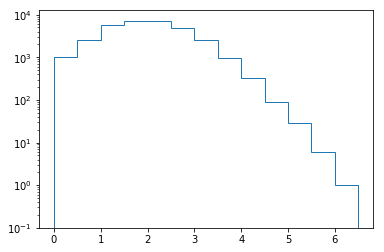

In [7]:
bins = bins = np.arange(min(tot), max(tot), 0.5)
num, bins, _ = plt.hist(tot, bins=bins, log=True, histtype='step')

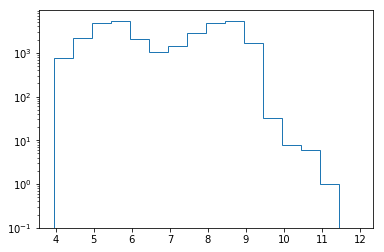

In [10]:
bins = bins = np.arange(min(tot), max(tot), 0.5)
num, bins, _ = plt.hist(tot, bins=bins, log=True, histtype='step')

In [13]:
bins.min()

3.951539415407902

In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
import scipy
from likelihoodRatioAnalysis import likelihoodfit

#file = dataio.I3File(str(infile))

gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
omgeo = geometry.omgeo
print('loaded geometry')

tauLLR = ([])
eLLR = ([])
rejected = ([])
for i in range(90, 110):
    print(i)
    file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')

    for frame in file:
        print('Starting')
        numHitsinDOM = ([])
        numHits = ([])
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        #looping through doms that have physics hits
        for omkey in mcpeMap.keys():
            oKey = omgeo.get(omkey)

            '''
            Obtaining the timeList
            '''
            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)
            numHitsinDOM = np.append(tot_timeList, noise_timeList)

            #print(numHitsinDOM)

        numHits = np.append(numHits, sum(numHitsinDOM))
        log_numHits = np.log10(numHits[numHits > 0])
        print(log_numHits)
        if log_numHits > 0 and log_numHits <= 100:
            val, string = likelihoodfit(frame, omgeo)
            if string == 'tau':
                tauLLR = np.append(tauLLR, val)
            if string == 'e':
                eLLR = np.append(eLLR, val)
            if string == 'rejected events':
                rejected = np.append(rejected, val)

np.savetxt('/data/p-one/akatil/analysis/NuTau_NuE_20Events_allCharge_2DelLLR' + '_tau.csv', tauLLR, delimiter=',')
np.savetxt('/data/p-one/akatil/analysis/NuTau_NuE_20Events_allCharge_2DelLLR' + '_e.csv', eLLR, delimiter=',')


loaded geometry
90
Starting
[5.95121996]
Likelihood fit function called
event rejected
Starting
[6.21525613]
Likelihood fit function called
event rejected
Starting
[6.32758395]
Likelihood fit function called


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
likelihoodHelpers.py:58: RuntimeWarning: invalid value encountered in log
  L = model - (n*np.log(model))


Starting
[5.56483027]
Likelihood fit function called
event rejected
Starting
[6.23612422]
Likelihood fit function called
event rejected
Starting
[6.57303776]
Likelihood fit function called
event rejected
Starting
[5.83101325]
Likelihood fit function called
event rejected
Starting
[6.1133177]
Likelihood fit function called
event rejected
Starting
[8.66847186]
Likelihood fit function called
event rejected
Starting
[8.54285115]
Likelihood fit function called
event rejected
Starting
[5.99319844]
Likelihood fit function called
event rejected
Starting
[6.67184905]
Likelihood fit function called
event rejected
Starting
[5.91952361]
Likelihood fit function called


likelihoodHelpers.py:66: RuntimeWarning: invalid value encountered in log
  L = model - (n*np.log(model))


Starting
[8.80286253]
Likelihood fit function called
event rejected
91
Starting
[6.47994491]
Likelihood fit function called
event rejected
Starting
[5.78384673]
Likelihood fit function called
event rejected
Starting
[8.62681244]
Likelihood fit function called
event rejected
Starting
[7.39695435]
Likelihood fit function called
event rejected
Starting
[8.01609569]
Likelihood fit function called
event rejected
Starting
[5.62200475]
Likelihood fit function called
event rejected
Starting
[5.89090495]
Likelihood fit function called
event rejected
Starting
[8.66743339]
Likelihood fit function called
event rejected
Starting
[8.74877969]
Likelihood fit function called
event rejected
Starting
[5.5571355]
Likelihood fit function called
event rejected
Starting
[5.27848506]
Likelihood fit function called
event rejected
Starting
[8.52120219]
Likelihood fit function called
event rejected
Starting
[6.66330738]
Likelihood fit function called
event rejected
Starting
[8.85035514]
Likelihood fit function 

likelihoodHelpers.py:66: RuntimeWarning: divide by zero encountered in log
  L = model - (n*np.log(model))
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Starting
[4.90643346]
Likelihood fit function called
event rejected
Starting
[5.37080775]
Likelihood fit function called
event rejected
Starting
[5.10861253]
Likelihood fit function called
event rejected
Starting
[5.55224933]
Likelihood fit function called
event rejected
Starting
[7.77594062]
Likelihood fit function called


likelihoodHelpers.py:58: RuntimeWarning: divide by zero encountered in log
  L = model - (n*np.log(model))


Error in amp
Starting
[8.36758136]
Likelihood fit function called


likelihoodHelpers.py:58: RuntimeWarning: invalid value encountered in multiply
  L = model - (n*np.log(model))


Removing DOMs whose minimization is not successful
Starting
[7.2993069]
Likelihood fit function called
event rejected
Starting
[8.32907773]
Likelihood fit function called
Starting
[5.2705539]
Likelihood fit function called
event rejected
Starting
[4.77651317]
Likelihood fit function called
event rejected
Starting
[5.20009552]
Likelihood fit function called
event rejected
Starting
[8.04590036]
Likelihood fit function called
event rejected
Starting
[5.42622857]
Likelihood fit function called
event rejected
Starting
[8.10369259]
Likelihood fit function called
event rejected
93
Starting
[4.67018199]
Likelihood fit function called
event rejected
Starting
[4.95408114]
Likelihood fit function called
event rejected
Starting
[8.50440908]
Likelihood fit function called
event rejected
Starting
[8.12827172]
Likelihood fit function called
event rejected
Starting
[7.50534121]
Likelihood fit function called
Starting
[8.72428005]
Likelihood fit function called
event rejected
Starting
[5.28597338]
Like

likelihoodHelpers.py:66: RuntimeWarning: invalid value encountered in multiply
  L = model - (n*np.log(model))


Removing DOMs whose minimization is not successful
98
Starting
[5.52000317]
Likelihood fit function called
event rejected
Starting
[5.67757453]
Likelihood fit function called
event rejected
Starting
[5.56877156]
Likelihood fit function called
event rejected
Starting
[5.50706667]
Likelihood fit function called
event rejected
Starting
[8.64896464]
Likelihood fit function called
Starting
[5.43591861]
Likelihood fit function called
event rejected
Starting
[5.4686665]
Likelihood fit function called
Starting
[7.80017087]
Likelihood fit function called
event rejected
Starting
[8.14025936]
Likelihood fit function called
event rejected
Starting
[8.25631421]
Likelihood fit function called
Starting
[5.5066238]
Likelihood fit function called
event rejected
Starting
[9.01718872]
Likelihood fit function called
event rejected
Starting
[5.49921079]
Likelihood fit function called
event rejected
Starting
[8.82184458]
Likelihood fit function called
event rejected
Starting
[8.09885659]
Likelihood fit func

Starting
[6.21641266]
Likelihood fit function called
event rejected
Starting
[8.30432153]
Likelihood fit function called
event rejected
Starting
[6.141203]
Likelihood fit function called
Starting
[5.89269981]
Likelihood fit function called
event rejected
Starting
[6.13512614]
Likelihood fit function called
event rejected
Starting
[9.19373954]
Likelihood fit function called
event rejected
Starting
[6.0238101]
Likelihood fit function called
event rejected
106
Starting
[5.6994381]
Likelihood fit function called
Starting
[9.01847716]
Likelihood fit function called
event rejected
Starting
[5.57458706]
Likelihood fit function called
Starting
[8.7213933]
Likelihood fit function called
event rejected
Starting
[8.82619165]
Likelihood fit function called
event rejected
Starting
[5.72421841]
Likelihood fit function called
event rejected
Starting
[5.38555448]
Likelihood fit function called
event rejected
Starting
[5.51145954]
Likelihood fit function called
event rejected
Starting
[9.18328615]
Like

In [2]:
rejected.shape

(298,)

In [3]:
tauLLR.shape

(16,)

In [4]:
eLLR.shape

(22,)

(array([0.00723124, 0.00241041, 0.        , 0.0006026 , 0.00120521,
        0.0006026 , 0.0006026 , 0.        , 0.        , 0.0006026 ]),
 array([2.31763547e-03, 7.54325854e+01, 1.50862853e+02, 2.26293121e+02,
        3.01723389e+02, 3.77153656e+02, 4.52583924e+02, 5.28014192e+02,
        6.03444460e+02, 6.78874727e+02, 7.54304995e+02]),
 <a list of 10 Patch objects>)

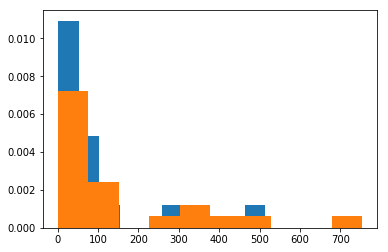

In [5]:
plt.hist(tauLLR, normed=True)
plt.hist(eLLR, normed=True)